# Imports

In [1]:
%matplotlib notebook
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from tabulate import tabulate
from sklearn.manifold import MDS
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
import math
import os

RANDOM_SEED = 42

# %matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mateosarja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import scipy
# scipy.test()

## Import Data
#### All Recipes

In [128]:
sources = ['allrecipes_0', 'allrecipes_1', 'allrecipes_2', 'allrecipes_3', 'allrecipes_4', '1M', 'bbc', 'epicurious', 'cookstr']
# sources = ['1M']
DATASET_DIR = './dataset'

df = pd.DataFrame()
pizza_filter = pd.read_csv(os.path.join(DATASET_DIR, 'pizzas/pizzas.csv'), names=['url'])
# print(pizza_filter.keys)

for source in sources:
    csv_path = os.path.join(DATASET_DIR, f'{source}.csv')
    try:
        one_source = pd.read_csv(csv_path, sep='|', engine='python',index_col=0)
    except Exception as e:
        print(f'{e} encountered at {source}')
        continue
        
    if source.startswith('allrecipes'):
        source = 'allrecipes'
        one_source = one_source[~one_source.url.isin(pizza_filter['url'])]
    
    one_source['source'] = source
        
    try:
        df = df.append(one_source)
    except Exception as e:
        print(f'{e} encountered at {source}')
        continue


In [129]:
print(df.head())
print(df.nunique())
# plt.figure()
# plt.hist(df['parsed_ingredient'].dropna())
# plt.show()
print(9)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<10].shape)
print(4)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<5].shape)
print(1)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<2].shape)
print(100)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()>100].shape)
print(df['parsed_ingredient'].value_counts()[:492].sum())
print(df['ingredient'].value_counts()[:492].sum())

                                  url  \
0  http://allrecipes.com/Recipe/6664/   
1  http://allrecipes.com/Recipe/6664/   
2  http://allrecipes.com/Recipe/6664/   
3  http://allrecipes.com/Recipe/6664/   
4  http://allrecipes.com/Recipe/6664/   

                                   ingredient  parsed_ingredient      source  
0  1/2 cup unsalted butter, chilled and cubed    unsalted butter  allrecipes  
1                         1 cup chopped onion              onion  allrecipes  
2                         1 3/4 cups cornmeal           cornmeal  allrecipes  
3                1 1/4 cups all-purpose flour  all-purpose flour  allrecipes  
4                         1/4 cup white sugar        white sugar  allrecipes  
url                  195771
ingredient           413251
parsed_ingredient     80968
source                    5
dtype: int64
9
(75738,)
4
(71897,)
1
(57664,)
100
(1060,)
1297376
643728


#### Remove Upper case letters, spec chars from ingredients

In [130]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–", "grams ", "oz ", 
              "ounces ", "ounce ", "tbsp ", "tsp ", "pkg ", 
              "package ", "packages ", "fl ", "gms ", "jar ", "can ", "ml ", "[0-9]"]

df['parsed_ingredient'] = df['parsed_ingredient'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['parsed_ingredient'] = df['parsed_ingredient'].str.lower()

for char in spec_chars:
    df['parsed_ingredient'] = df['parsed_ingredient'].str.replace(char, ' ')
    
df['parsed_ingredient'] = df['parsed_ingredient'].str.split().str.join(" ")


In [132]:
print(df.head())
print(df.nunique())
# plt.figure()
# plt.hist(df['parsed_ingredient'].dropna())
# plt.show()
print(9)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<10].shape)
print(4)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<5].shape)
print(1)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<2].shape)
print(100)
print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()>100].shape)
# print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()<2])
print(df['parsed_ingredient'].value_counts().sum())

                                  url  \
0  http://allrecipes.com/Recipe/6664/   
1  http://allrecipes.com/Recipe/6664/   
2  http://allrecipes.com/Recipe/6664/   
3  http://allrecipes.com/Recipe/6664/   
4  http://allrecipes.com/Recipe/6664/   

                                   ingredient  parsed_ingredient      source  
0  1/2 cup unsalted butter, chilled and cubed    unsalted butter  allrecipes  
1                         1 cup chopped onion              onion  allrecipes  
2                         1 3/4 cups cornmeal           cornmeal  allrecipes  
3                1 1/4 cups all-purpose flour  all purpose flour  allrecipes  
4                         1/4 cup white sugar        white sugar  allrecipes  
url                  195771
ingredient           413251
parsed_ingredient     65957
source                    5
dtype: int64
9
(61093,)
4
(57728,)
1
(45478,)
100
(1048,)
1633930


In [17]:
tot = df['parsed_ingredient'].shape[0]

for i in [1000, 500, 100, 50, 10, 1]:
    print(i)
    keep = df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()>i].sum()
    print(df['parsed_ingredient'].value_counts()[df['parsed_ingredient'].value_counts()>i].shape)
    print(round((keep)/tot, 3)*100)
    print()

1000
(244,)
69.39999999999999

500
(378,)
74.9

100
(1048,)
83.5

50
(1612,)
85.9

10
(4542,)
89.60000000000001

1
(20479,)
92.9



#### Generate table for manual labelling

In [6]:
# counts = df['parsed_ingredient'].value_counts()
# pd.Series(counts[:1000].index).to_csv('dataset/final_ingredients/ingredient_names.csv', index=False)

#### Add manual labelling of data

In [19]:
num_ingredients = 500    ### Max of 500, but adds noise

csv_path = 'dataset/final_ingredients/mapped_names.csv'
try:
    ing_map = pd.read_csv(csv_path, sep=',', engine='python')
except Exception as e:
    print(f'{e} encountered at {source}')
ing_map = ing_map.loc[ing_map['mapped_ingredient'] != 'NO INGREDIENT']

ing_map = dict(zip(ing_map['parsed_ingredient'], ing_map['mapped_ingredient']))
df['ingredient'] = df['parsed_ingredient'].map(ing_map)
ingredients = df.dropna()
ingredients = ingredients.drop(['parsed_ingredient'], axis=1)
ingredients.drop_duplicates(inplace=True)
counts = ingredients['ingredient'].value_counts()
ing_to_keep = counts[:num_ingredients].index
ingredients = ingredients[ingredients['ingredient'].isin(ing_to_keep)]
ingredient_list = ingredients['ingredient'].unique()
ingredients.head()

url ingredient      source
0  http://allrecipes.com/Recipe/6664/     butter  allrecipes
1  http://allrecipes.com/Recipe/6664/      onion  allrecipes
2  http://allrecipes.com/Recipe/6664/   cornmeal  allrecipes
3  http://allrecipes.com/Recipe/6664/      flour  allrecipes
4  http://allrecipes.com/Recipe/6664/      sugar  allrecipes

In [20]:
counts = ingredients['ingredient'].value_counts()
# print(counts[:250])
# plt.figure()
# plt.plot(counts)
# plt.show()
# counts.to_dict()

## Load Rated Recipes

In [21]:
sources = ['epicurious', 'allrecipes']
# sources= ['allrecipes']
DATASET_DIR = './dataset'

ratings = pd.DataFrame()
pizza_filter = pd.read_csv(os.path.join(DATASET_DIR, 'pizzas/pizzas.csv'), names=['url'])

for source in sources:
    one_source = pd.read_csv(os.path.join(DATASET_DIR, f'ratings/{source}_ratings.csv'))
    
    if source == 'allrecipes':
        one_source = one_source[~one_source.url.isin(pizza_filter['url'])]
        
    try:
        ratings = ratings.append(one_source)
    except Exception as e:
        print(f'{e} encountered at {source}')
        continue
ratings = ratings.replace([0.0], np.nan).dropna() # Remove recipes that weren't rated
ratings = ratings[ratings.url.isin(ingredients.url)] # Remove rated recipes that do not appear in the final dataset
ratings.set_index('url', drop=True, inplace=True)
ratings.shape


(30308, 3)

In [22]:
rated_recipes = ingredients[ingredients.url.isin(ratings.index)].drop('source', axis=1)
rated_recipes = rated_recipes.groupby('url')['ingredient'].value_counts().unstack().fillna(0)
recipes = ingredients.groupby('url')['ingredient'].value_counts().unstack().fillna(0)
rated_recipes_count = rated_recipes.sum(axis=1)
rated_recipes.head()

ingredient                                          acorn squash  \
url                                                                
/recipes/food/views/-adult-pimiento-cheese-100852            0.0   
/recipes/food/views/-an-apple-a-day-51133430                 0.0   
/recipes/food/views/-blanketed-eggplant-305                  0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...           0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...           0.0   

ingredient                                          active dry yeast  \
url                                                                    
/recipes/food/views/-adult-pimiento-cheese-100852                0.0   
/recipes/food/views/-an-apple-a-day-51133430                     0.0   
/recipes/food/views/-blanketed-eggplant-305                      0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...               0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...               0.0   

ingredient                                          agave nectar  allspice  \
url                                                                          
/recipes/food/views/-adult-pimiento-cheese-100852            0.0       0.0   
/recipes/food/views/-an-apple-a-day-51133430                 0.0       0.0   
/recipes/food/views/-blanketed-eggplant-305                  0.0       0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...           0.0       0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...           0.0       0.0   

ingredient                                          almond butter  \
url                                                                 
/recipes/food/views/-adult-pimiento-cheese-100852             0.0   
/recipes/food/views/-an-apple-a-day-51133430                  0.0   
/recipes/food/views/-blanketed-eggplant-305                   0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...            0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...            0.0   

ingredient                                          almond extract  \
url                                                                  
/recipes/food/views/-adult-pimiento-cheese-100852              0.0   
/recipes/food/views/-an-apple-a-day-51133430                   0.0   
/recipes/food/views/-blanketed-eggplant-305                    0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...             0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...             0.0   

ingredient                                          almond flour  almond milk  \
url                                                                             
/recipes/food/views/-adult-pimiento-cheese-100852            0.0          0.0   
/recipes/food/views/-an-apple-a-day-51133430                 0.0          0.0   
/recipes/food/views/-blanketed-eggplant-305                  0.0          0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...           0.0          0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...           0.0          0.0   

ingredient                                          almond paste  almonds  \
url                                                                         
/recipes/food/views/-adult-pimiento-cheese-100852            0.0      0.0   
/recipes/food/views/-an-apple-a-day-51133430                 0.0      1.0   
/recipes/food/views/-blanketed-eggplant-305                  0.0      0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...           0.0      0.0   
/recipes/food/views/-bow-tie-pasta-with-zucchin...           0.0      0.0   

ingredient                                          ...  white wine vinegar  \
url                                                 ...                       
/recipes/food/views/-adult-pimiento-cheese-100852   ...                 0.0   
/recipes/food/views/-an-apple-a-day-51133430        ...                 0.0   
/recipes/food/views/-blanketed-eggplant-305         ...                 

#### Identify underrepresented ingredients in rated dataset

In [23]:
rated_ingredients = rated_recipes.columns
missing_ingredients = set(ingredient_list) - set(rated_ingredients)
print(missing_ingredients)
# print(ingredient_list)

{'onion soup', 'icing', 'creamy salad dressing', 'pie dough', 'italian dressing', 'mandarin', 'chocolate pudding', 'pancake', 'whiskey', 'jam', 'rapeseed oil', 'sweetener', 'groundnut oil', 'cream of celery soup', 'stevia', 'protein powder', 'pepperjack cheese', 'glaze', 'biscuit baking mix'}


## Drop missing ingredients from full ingredient list
(Missing from rated recipes)

In [24]:
num_ingredients = 500    ### Max of 500, but adds noise

csv_path = 'dataset/final_ingredients/mapped_names.csv'
try:
    ing_map = pd.read_csv(csv_path, sep=',', engine='python')
except Exception as e:
    print(f'{e} encountered at {source}')


ing_map = ing_map[~ing_map['mapped_ingredient'].isin(missing_ingredients)]
ing_map = ing_map.loc[ing_map['mapped_ingredient'] != 'NO INGREDIENT']
# ing_map['mapped_ingredient'].value_counts()
ing_map = dict(zip(ing_map['parsed_ingredient'], ing_map['mapped_ingredient']))

df['ingredient'] = df['parsed_ingredient'].map(ing_map)
ingredients = df.dropna()
ingredients = ingredients.drop(['parsed_ingredient'], axis=1)
ingredients.drop_duplicates(inplace=True)

counts = df['ingredient'].value_counts()
ing_to_keep = counts[:num_ingredients].index
ingredients = ingredients[ingredients['ingredient'].isin(ing_to_keep)]
ingredient_list = np.sort(ingredients['ingredient'].unique())

#### Basic data stats

In [25]:
sources = ['1M', 'allrecipes', 'bbc', 'epicurious', 'cookstr']
# sources = ['1M']

stats_dict = {
    'Source' : ['Num ing', 'Num rec', 'Mean ing/rec', 'Unique ing', 'Mean Ing Freq']
}

N_INGREDIENTS = ingredients.nunique()[1]

##### Before Manual Labelling
print('Stats before manual labelling')
for source in sources:
    if source == 'total':
        continue
        
    one_source = df.loc[df['source']==source]
    stats_dict[source] = [
            one_source.shape[0], 
            one_source.nunique()[0], 
            round(one_source.shape[0] / one_source.nunique()[0], 2), 
            one_source.nunique()[2],
            round(one_source.shape[0] / one_source.nunique()[2], 2)
        ]
    
pre_clean_ing_num = df.shape[0]
stats_dict['total'] = [
        df.shape[0], 
        df.nunique()[0], 
        round(df.shape[0] / df.nunique()[0], 2), 
        df.nunique()[2],
        round(df.shape[0] / df.nunique()[2], 2)
    ]
    
print(tabulate(stats_dict, headers='keys', tablefmt='fancy_grid', numalign="right"))




#### After Manual labelling
print('Stats after manual labelling')
for source in sources:
    if source == 'total':
        continue
        
    one_source = ingredients.loc[ingredients['source']==source]
    stats_dict[source] = [
            one_source.shape[0], 
            one_source.nunique()[0], 
            round(one_source.shape[0] / one_source.nunique()[0], 2), 
            one_source.nunique()[1],
            round(one_source.shape[0] / one_source.nunique()[1], 2)
        ]
    
post_clean_ing_num = ingredients.shape[0]    
stats_dict['total'] = [
        ingredients.shape[0], 
        ingredients.nunique()[0], 
        round(ingredients.shape[0] / ingredients.nunique()[0], 2), 
        ingredients.nunique()[1],
        round(ingredients.shape[0] / ingredients.nunique()[1], 2)
    ]
    
print(tabulate(stats_dict, headers='keys', tablefmt='fancy_grid', numalign="right"))

print(f'{round(post_clean_ing_num / pre_clean_ing_num, 3)*100}% of ingredients still remaining after cleaning ')

Stats before manual labelling
╒═══════════════╤═════════╤══════════════╤════════╤══════════════╤═══════════╤═════════════╕
│ Source        │      1M │   allrecipes │    bbc │   epicurious │   cookstr │       total │
╞═══════════════╪═════════╪══════════════╪════════╪══════════════╪═══════════╪═════════════╡
│ Num ing       │  311435 │       835805 │ 139535 │       341299 │     81340 │ 1.70941e+06 │
├───────────────┼─────────┼──────────────┼────────┼──────────────┼───────────┼─────────────┤
│ Num rec       │   51196 │        91385 │  10599 │        34673 │      7918 │      195771 │
├───────────────┼─────────┼──────────────┼────────┼──────────────┼───────────┼─────────────┤
│ Mean ing/rec  │    6.08 │         9.15 │  13.16 │         9.84 │     10.27 │        8.73 │
├───────────────┼─────────┼──────────────┼────────┼──────────────┼───────────┼─────────────┤
│ Unique ing    │     288 │        32728 │   8413 │        26012 │     11032 │       65957 │
├───────────────┼─────────┼─────────────

# Build Occurence Matrix
Log Distance

In [60]:
tmp = ingredients.drop('source', axis=1)
tmp = pd.merge(tmp, tmp, on='url')
tmp = tmp[tmp['ingredient_x'] != tmp['ingredient_y']]
tmp.drop('url', axis=1, inplace=True)
edge_matrix = tmp.groupby(['ingredient_x', 'ingredient_y']).size().unstack().fillna(0)   # Dissimilarity matrix

tmp = tmp.groupby(['ingredient_x', 'ingredient_y']).size().to_frame('pair_freq').reset_index()
filter_dups = pd.DataFrame(np.sort(tmp[['ingredient_x','ingredient_y']], axis=1))
edge_list = tmp[~filter_dups.duplicated()].sort_values(by='pair_freq', ascending=False)
edge_list = edge_list.reset_index(drop=True)     # Edge List
# edge_list.to_csv('dataset/graph/edge_list.csv')

In [73]:
# edge_matrix.max().max()
edge_matrix.loc['salt','sugar']

26509.0

In [109]:
scale = 26600
# scale = 1

distance_matrix = edge_matrix.apply(lambda x: np.log(scale/x)) # Scales up distances so that all are positive

distance_matrix = distance_matrix.replace([np.inf, -np.inf], np.nan)    # Replace inf with arbitrarily large number

print(f'{int((distance_matrix.isna().sum().sum() - distance_matrix.shape[0])/2)} pairs out of {int((distance_matrix.shape[0]**2 - distance_matrix.shape[0])/2)} do not occur together at any point')

distance_matrix = distance_matrix.replace(np.nan, 1.2 * distance_matrix.max().max())    # Replace inf with arbitrarily large number

for i in distance_matrix.index:
    distance_matrix.loc[i,i] = 0

mds = MDS(n_components=2, 
           metric=True, 
           n_init=10, 
           max_iter=1000,
           random_state=RANDOM_SEED, 
           dissimilarity='precomputed')

mds_out = mds.fit_transform(distance_matrix)
mds_out_df = pd.DataFrame(mds_out)
mds_out_df.index = distance_matrix.index


# print(distance_matrix.stack().reset_index())
# graph_edge_list = edge_list[edge_list['pair_freq']>100]
# labels = graph_edge_list['ingredient_x'].unique()
# node_sizes = ingredients['ingredient'].value_counts().apply(grouping_fn)


# stacked = distance_matrix.stack().reset_index()

# plt.figure()

# G = nx.from_pandas_edgelist(stacked, source='ingredient_x', target='ingredient_y', create_using=nx.Graph())

# # nx.draw(G, node_size=node_sizes, labels=labels ,with_labels=True, width=0.01)
# nx.draw(G, node_size=2, with_labels=True, width=0.01)

52854 pairs out of 119805 do not occur together at any point


<IPython.core.display.Javascript object>


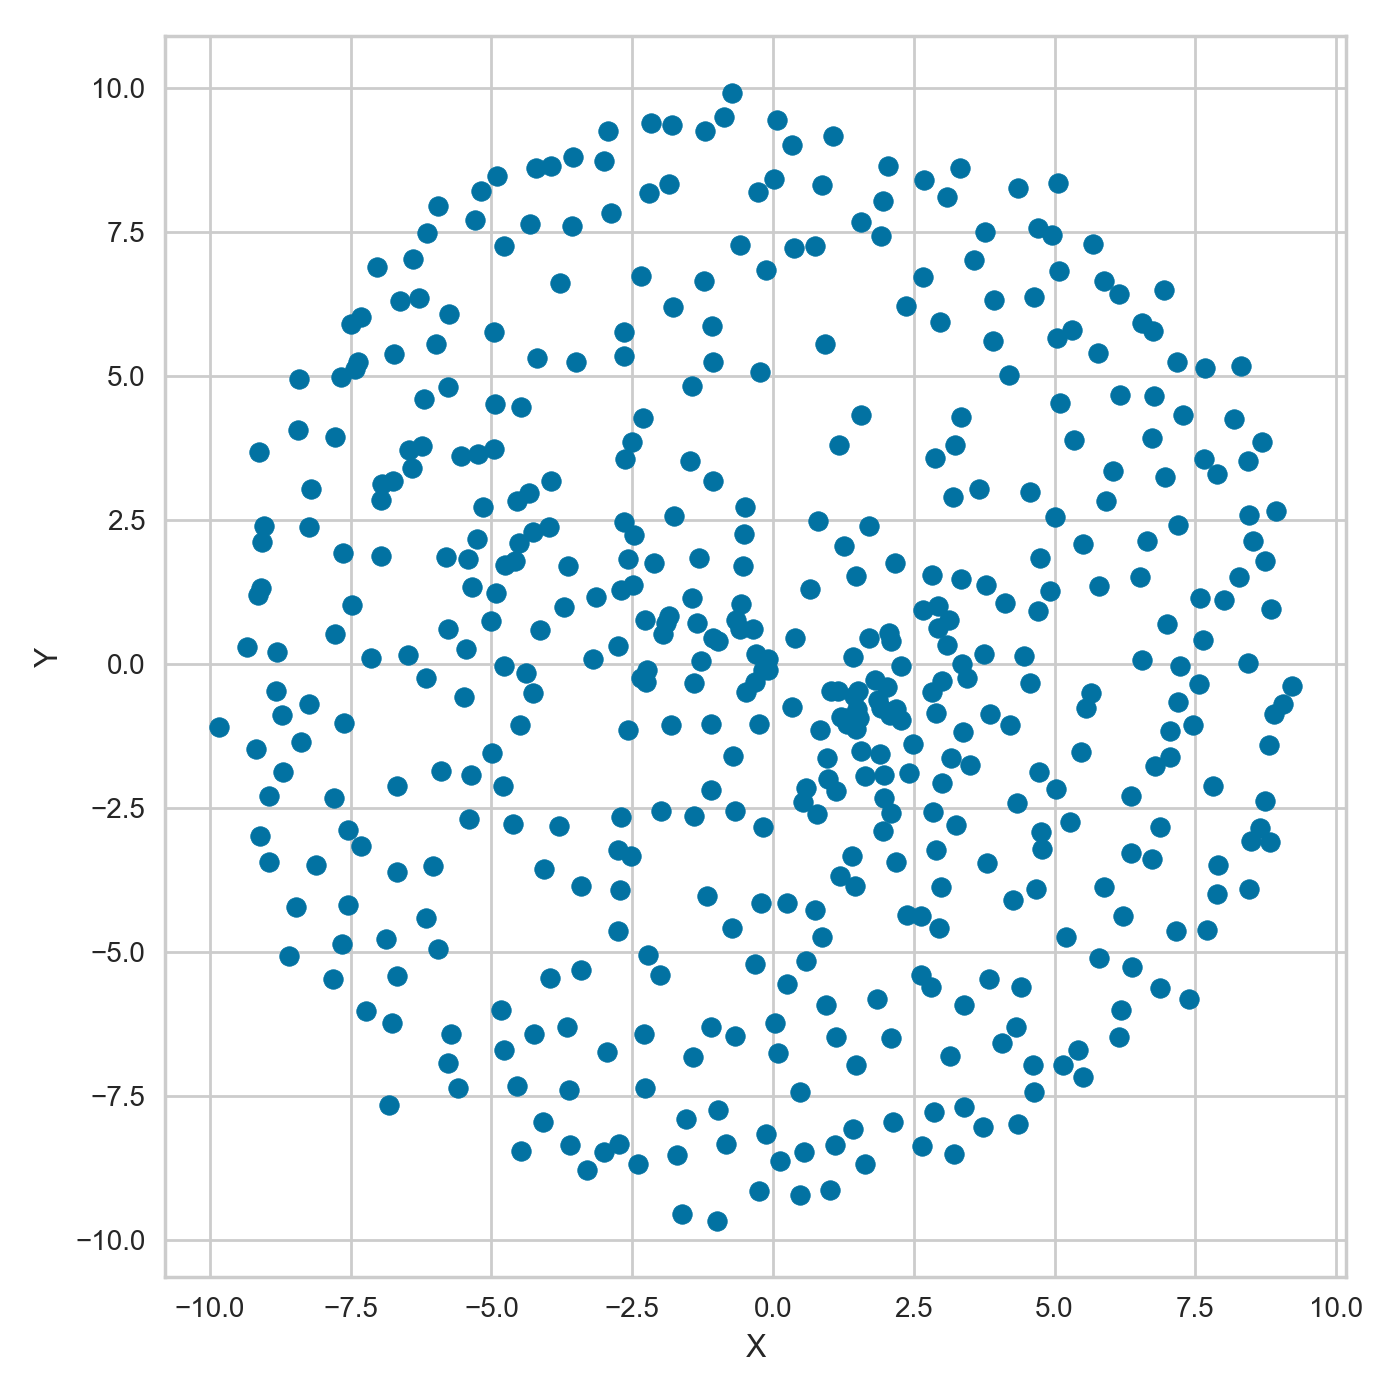

In [110]:
plt.figure(figsize=(7,7))
plt.scatter(mds_out[:,0], mds_out[:,1])
# plt.title('Ingredient Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

### K-Means Clustering

In [111]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer


X = mds_out_df.replace([np.inf], np.nan)
X = X.replace(np.nan, X.max()*2 )
# X = pd.DataFrame(out).replace([-np.inf], np.nan)
# X = X.replace(np.nan, -X.max()*2 )


# model = KMeans(random_state=RANDOM_SEED)
# plt.figure(figsize=(9,9))
# plt.subplot(311)

# visualizer = KElbowVisualizer(model, metric='calinski_harabasz', k=(2,20))

# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()

# # plt.figure(figsize=(9,15))
# plt.subplot(312)

# visualizer = KElbowVisualizer(model, metric='silhouette', k=(2,20))

# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()

# # plt.figure(figsize=(9,9))
# plt.subplot(313)

# visualizer = KElbowVisualizer(model, k=(2,20))

# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()

<IPython.core.display.Javascript object>


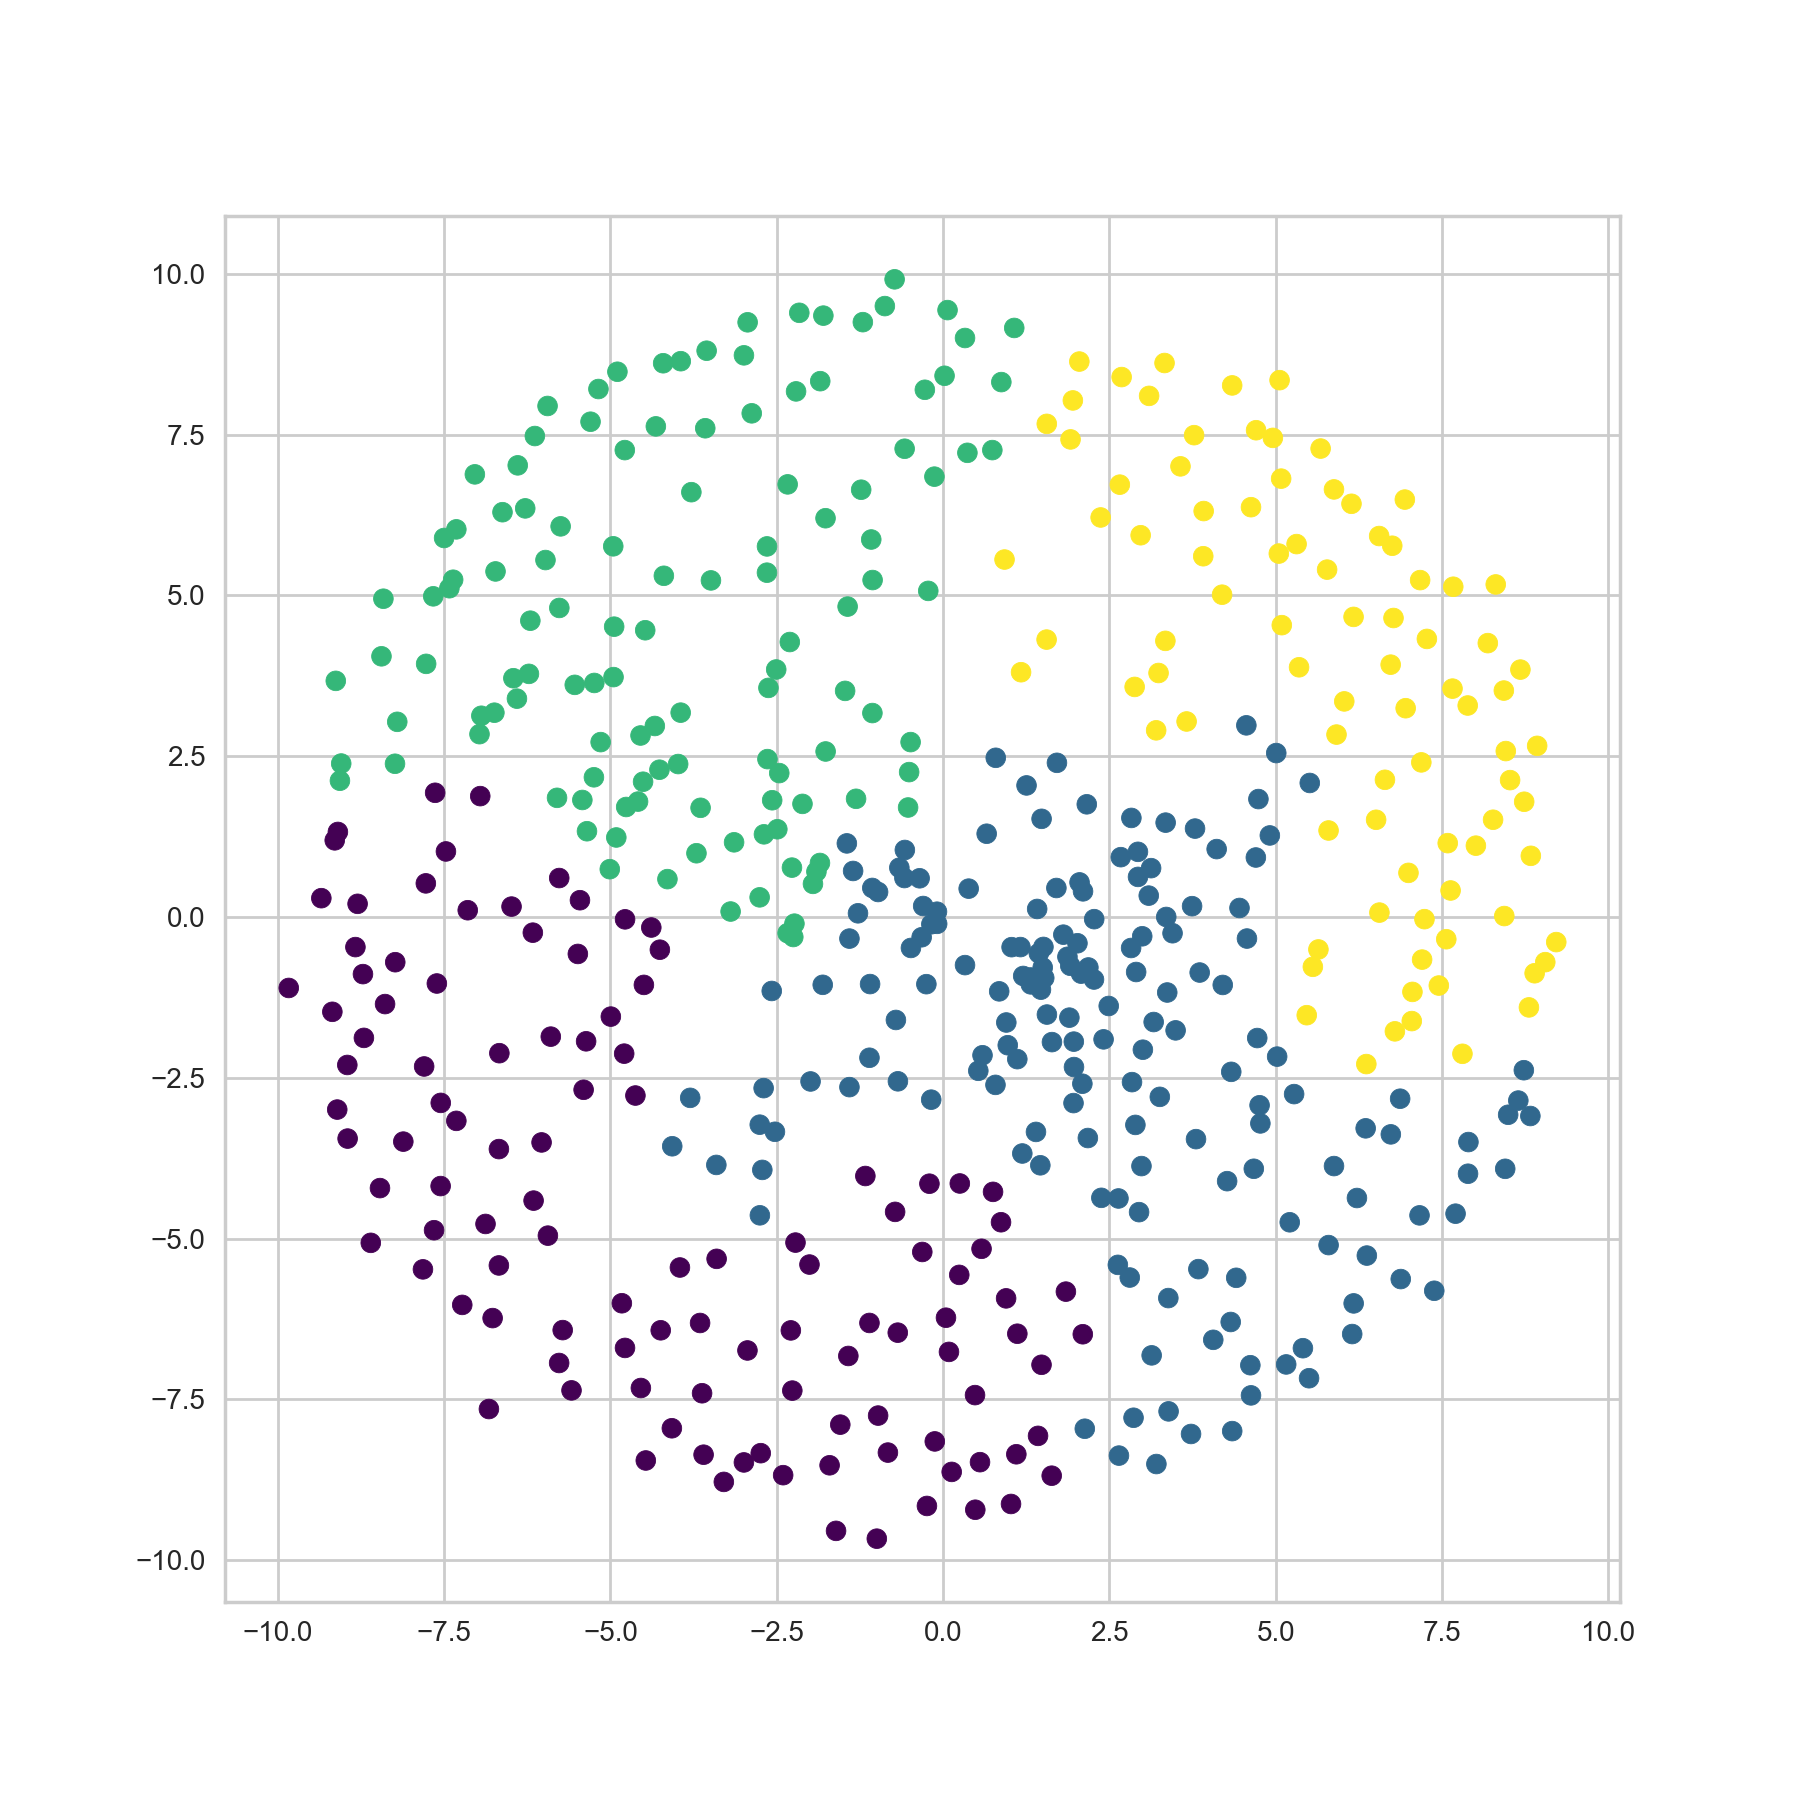

In [112]:
# X = mds_out_df.replace([np.inf], np.nan)
# X = X.replace(np.nan, X.max()*2 )

model = AgglomerativeClustering(4)
clusters = model.fit_predict(mds_out_df)
mds_out_df['cluster'] = clusters

plt.figure(figsize=(9,9))
plt.scatter(mds_out[:, 0], mds_out[:, 1], c=clusters, s=50, cmap='viridis')

# centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [120]:
# mds_out = pd.DataFrame(out).set_index(ingredient_list, drop=True)
mds_out_df['cluster'] = clusters
print(mds_out_df[mds_out_df['cluster']==0])

                          0         1  cluster
ingredient_x                                  
acorn squash      -4.781726 -6.701073        0
agave nectar      -7.317181 -3.170833        0
almond flour      -8.388856 -1.355128        0
almond milk       -7.610312 -1.035205        0
angostura bitters -8.603464 -5.067392        0
apple juice       -4.386467 -0.164758        0
apricot           -4.257654 -0.509713        0
bean sprouts       1.427486 -8.068343        0
berries           -9.346829  0.291414        0
blackberries      -6.957898  1.878143        0
bok choy           0.484368 -9.216748        0
bourbon           -7.473870  1.017825        0
brown rice         1.846247 -5.825790        0
brussel sprout     0.480242 -7.434765        0
bulgur            -3.623108 -7.405751        0
butternut squash  -0.721025 -4.585800        0
cantaloupe        -7.553455 -4.184708        0
caraway seeds     -2.218637 -5.063357        0
cardamom          -4.497766 -1.056893        0
cardamom pods

### Clustering -- PMI

In [74]:
# scale = 50000
scale = 1

recipes_per_ingredient = edge_matrix.sum()
total_num_recipes = edge_matrix.sum().sum()

pmi_matrix = pd.DataFrame()


# # Calculate PMI

for x in edge_matrix.index:
    for y in edge_matrix.index:
        numerator = edge_matrix.loc[x,y] / total_num_recipes
        denominator = (recipes_per_ingredient[x] * recipes_per_ingredient[y]) / (total_num_recipes**2)
        pmi = numerator / denominator
        pmi_matrix.loc[x,y] = np.log(scale * pmi)     # Scale to keep all distances positive


max_val = pmi_matrix.max().max()
pmi_matrix = pmi_matrix.apply(lambda x: max_val - x)

pmi_matrix = pmi_matrix.replace([np.inf, -np.inf], np.nan)    # Replace inf with nan

# print(f'{int((pmi_matrix.isna().sum().sum() - pmi_matrix.shape[0])/2)} pairs out of {int((pmi_matrix.shape[0]**2 - pmi_matrix.shape[0])/2)} do not occur together at any point')

pmi_matrix = pmi_matrix.replace(np.nan, pmi_matrix.max().max() / 5 )    # Replace inf with arbitrarily small number

for i in pmi_matrix.index:
    pmi_matrix.loc[i,i] = 0


mds = MDS(n_components=2, 
           metric=True, 
           n_init=10, 
           max_iter=1000,
           random_state=RANDOM_SEED, 
           dissimilarity='precomputed')

pmi_out = mds.fit_transform(pmi_matrix)
pmi_out_df = pd.DataFrame(pmi_out)
pmi_out_df.index = distance_matrix.index

# stacked = pmi_matrix.stack().reset_index()
# stacked.columns = 'ingredient_x', 'ingredient_y', 'pmi'
# print(stacked)
# plt.figure()

# G = nx.from_pandas_edgelist(stacked, source='ingredient_x', target='ingredient_y', create_using=nx.Graph())

# # nx.draw(G, node_size=node_sizes, labels=labels ,with_labels=True, width=0.01)
# nx.draw(G, node_size=2, with_labels=True, width=0.01)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


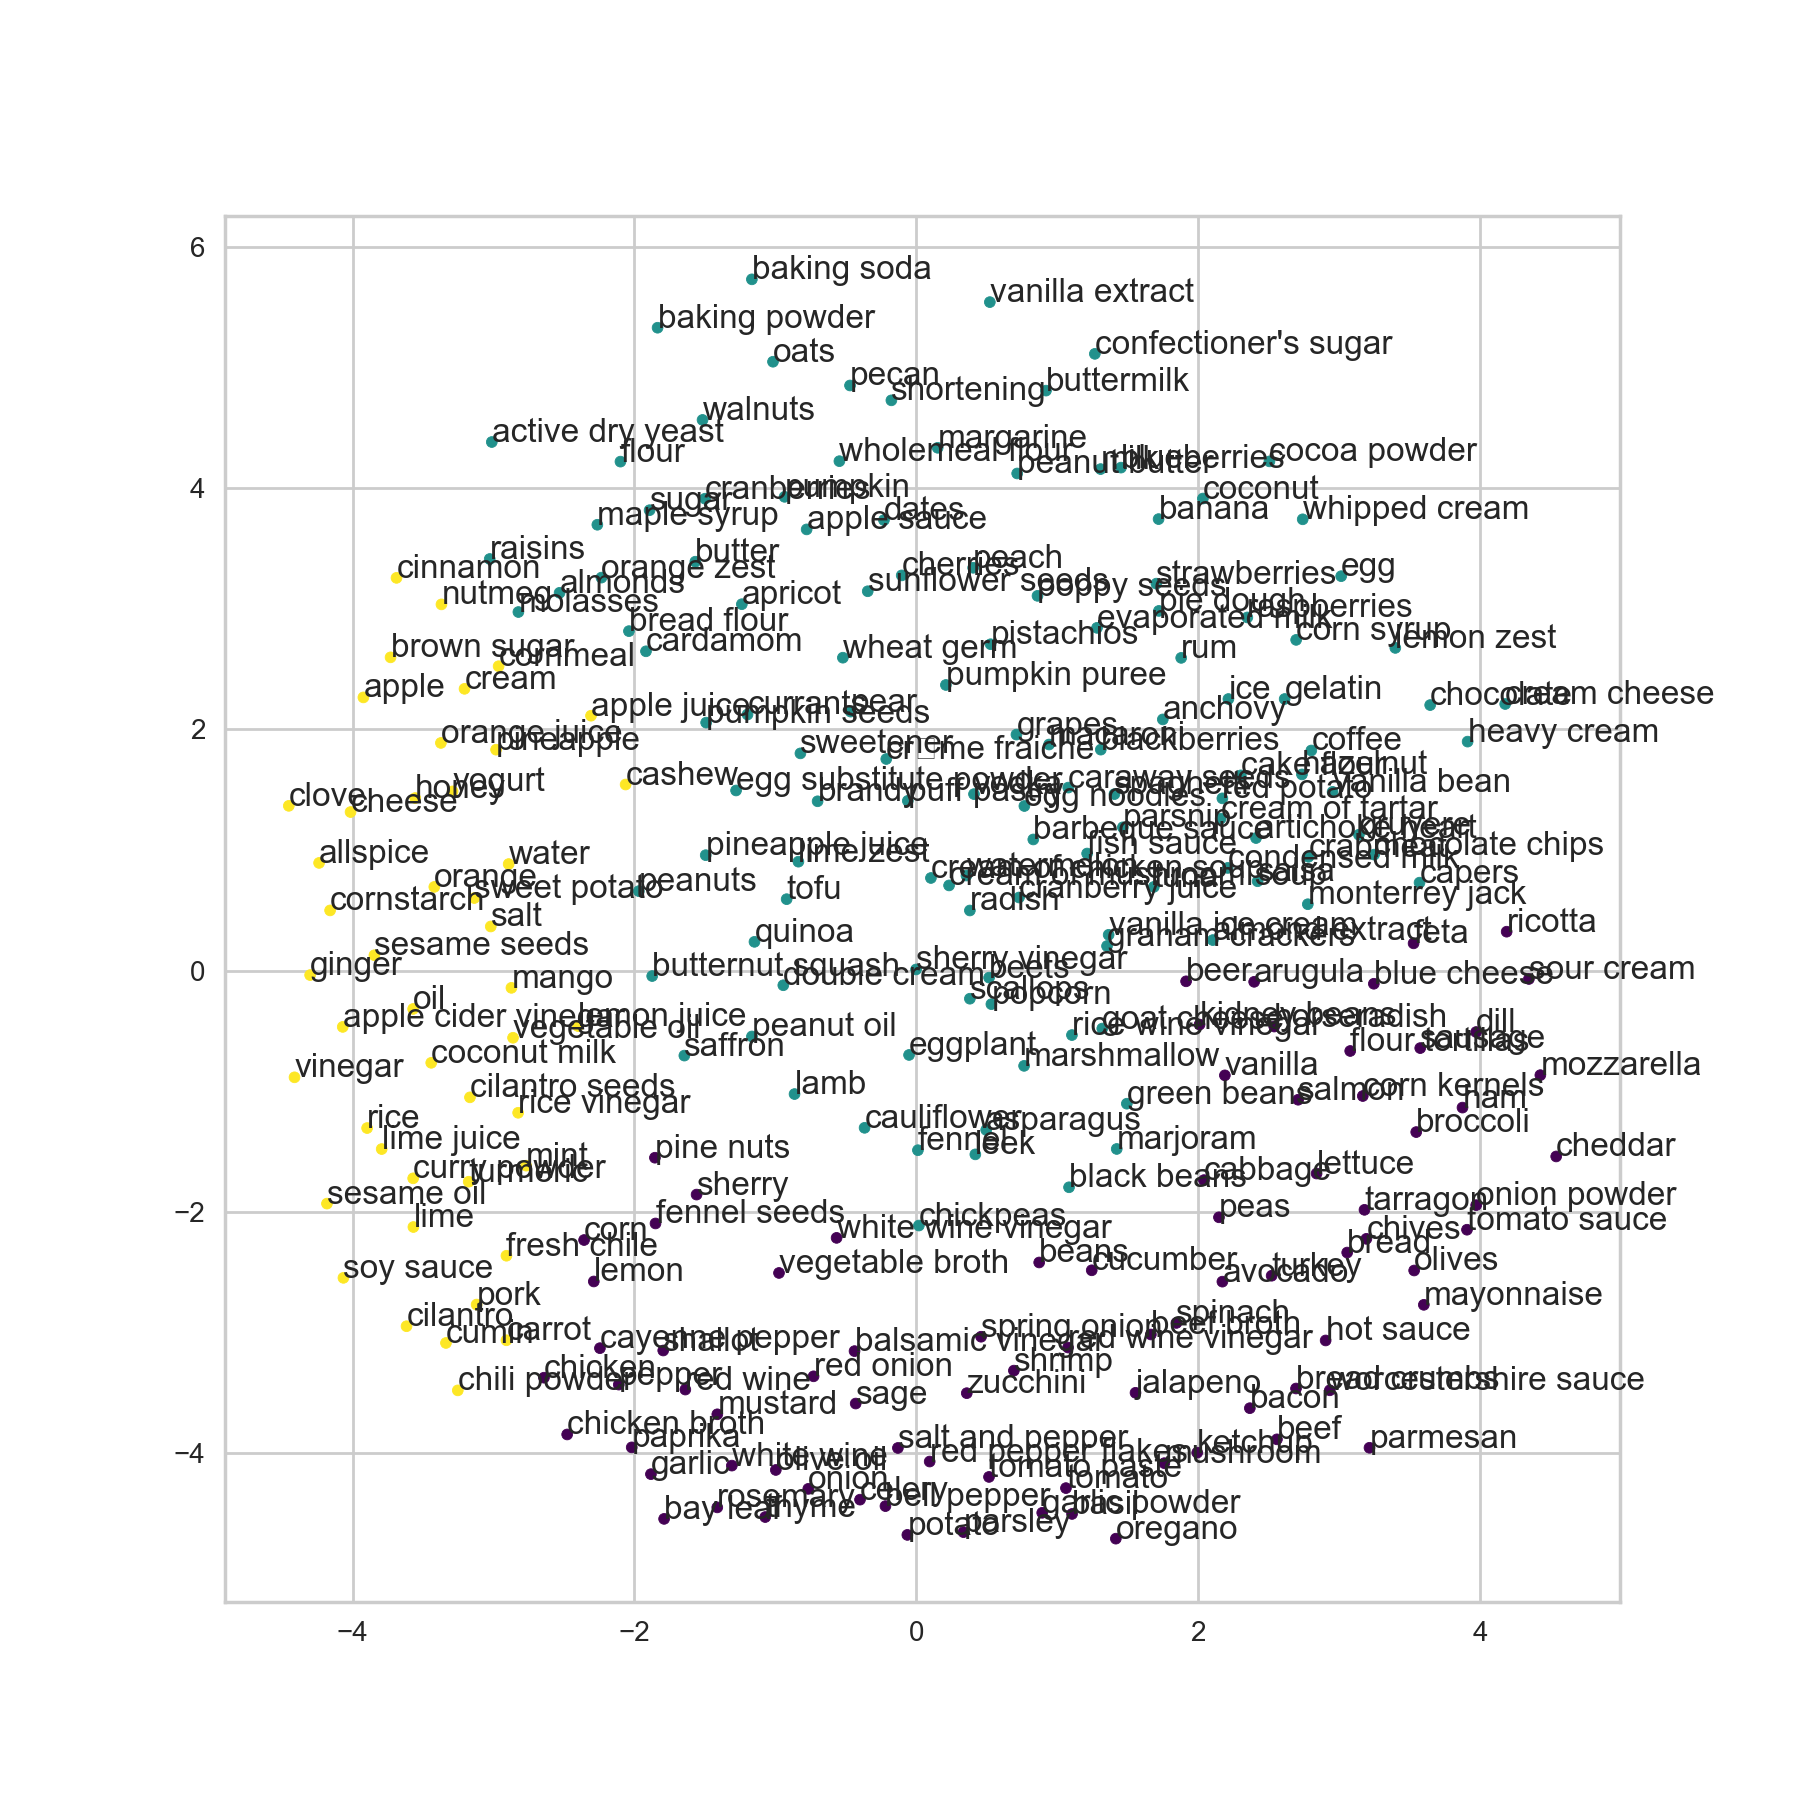

In [76]:
model = AgglomerativeClustering(3)
clusters = model.fit_predict(pmi_out_df)
pmi_out_df['cluster'] = clusters

plt.figure(figsize=(9,9))
plt.scatter(pmi_out[:, 0], pmi_out[:, 1], c=clusters, s=15, cmap='viridis')

# centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

for idx, label in enumerate(pmi_out_df.index):
    plt.annotate(label, (pmi_out[idx, 0], pmi_out[idx, 1]))

plt.show()

In [69]:
# pmi_out_df['cluster'] = clusters
# pmi_out_df['cluster'].value_counts()
# print(pmi_out_df[pmi_out_df['cluster']==0])

# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(10, 7))
# plt.subplot(211)
# plt.title("Ingredient Dendograms  -  Freq Distance")
# plt.grid()
# dend = shc.dendrogram(shc.linkage(mds_out, method='ward'))
# plt.subplot(212)
# plt.title("Ingredient Dendograms  -  PMI")
# plt.grid()
# dend = shc.dendrogram(shc.linkage(pmi_out, method='ward'))

# pmi_out_df['cluster'] = clusters
# pmi_out_df['cluster'].value_counts()
# print(pmi_out_df[pmi_out_df['cluster']==10])

<IPython.core.display.Javascript object>


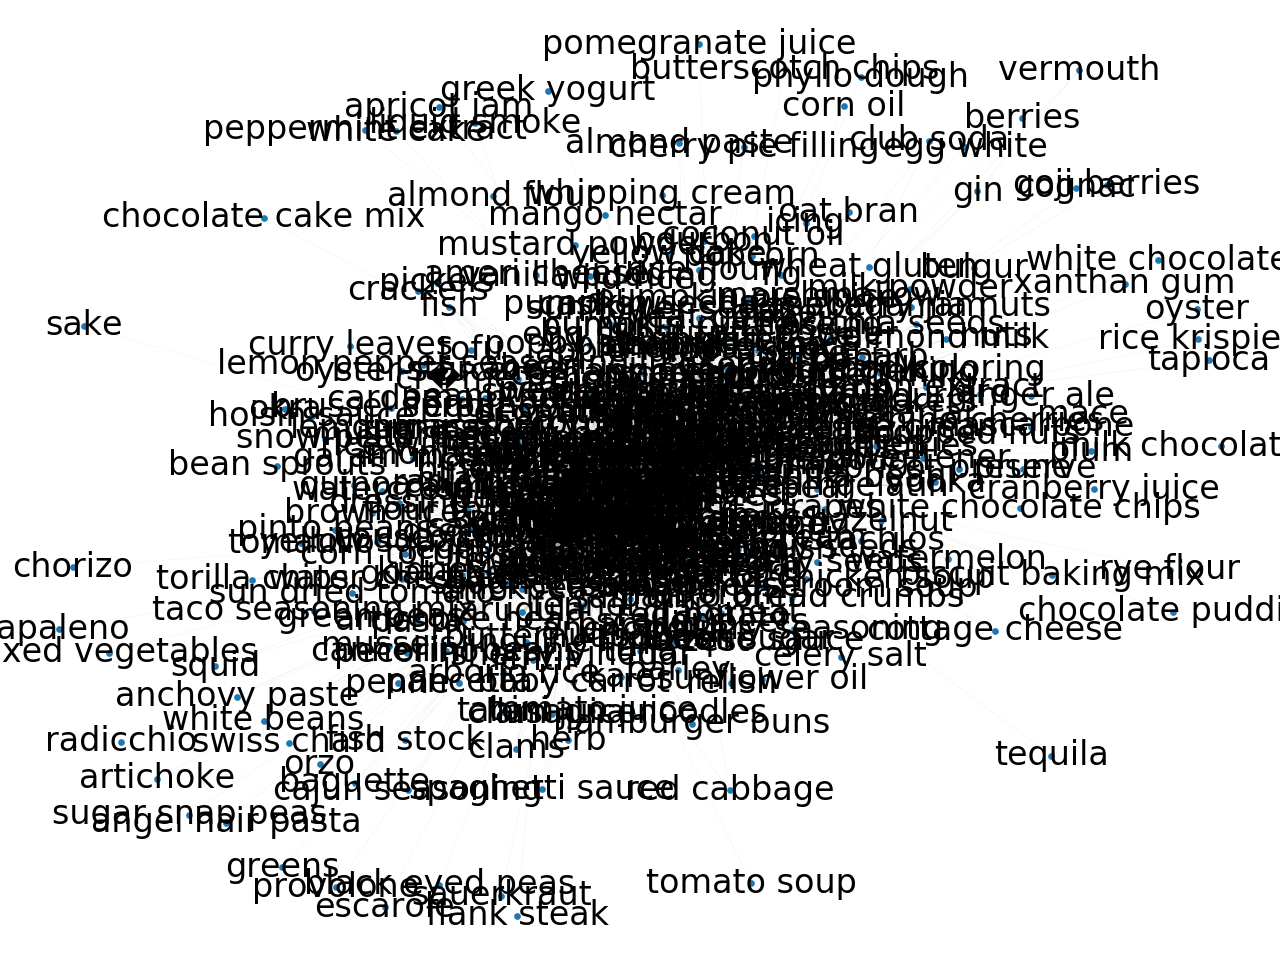

In [186]:
def grouping_fn(x):
    if x > 20000:
        return 100
    elif x > 10000:
        return 50
    elif x > 1000:
        return 10
    else:
        return 1
    
graph_edge_list = edge_list[edge_list['pair_freq']>100]
labels = graph_edge_list['ingredient_x'].unique()
node_sizes = ingredients['ingredient'].value_counts().apply(grouping_fn)

plt.figure()

G = nx.from_pandas_edgelist(graph_edge_list, source='ingredient_x', target='ingredient_y', create_using=nx.Graph())

# nx.draw(G, node_size=node_sizes, labels=labels ,with_labels=True, width=0.01)
nx.draw(G, node_size=2, with_labels=True, width=0.01)


### Clustering  --- IOU

In [64]:
# scale = 50
scale = 1

recipes_per_ingredient = edge_matrix.sum()
total_num_recipes = edge_matrix.sum().sum()

iou_matrix = pd.DataFrame()


# Calculate PMI
for x in edge_matrix.index:
    for y in edge_matrix.index:
        numerator = edge_matrix.loc[x,y] 
        denominator = recipes_per_ingredient[x] + recipes_per_ingredient[y] - edge_matrix.loc[x,y]
        iou = numerator / denominator
        iou_matrix.loc[x,y] = scale * iou     # Scale to keep all distances positive

        
# max_val = iou_matrix.max().max()
# iou_matrix = iou_matrix.apply(lambda x: max_val - x)

# iou_matrix = iou_matrix.replace([np.inf, -np.inf], np.nan)    # Replace inf with nan

# print(f'{int((pmi_matrix.isna().sum().sum() - pmi_matrix.shape[0])/2)} pairs out of {int((pmi_matrix.shape[0]**2 - pmi_matrix.shape[0])/2)} do not occur together at any point')

# iou_matrix = iou_matrix.replace(np.nan, iou_matrix.max().max() / 5 )    # Replace inf with arbitrarily small number

# for i in pmi_matrix.index:
#     pmi_matrix.loc[i,i] = 0


mds = MDS(n_components=2, 
           metric=True, 
           n_init=10, 
           max_iter=1000,
           random_state=RANDOM_SEED, 
           dissimilarity='precomputed')

iou_out = mds.fit_transform(iou_matrix)
iou_out_df = pd.DataFrame(iou_out)
iou_out_df.index = distance_matrix.index


In [66]:
model = AgglomerativeClustering(2)
clusters = model.fit_predict(iou_out_df)
iou_out_df['cluster'] = clusters

# plt.figure(figsize=(9,9))
# plt.scatter(iou_out[:, 0], iou_out[:, 1], c=clusters, s=15, cmap='viridis')

# centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# for idx, label in enumerate((pmi_out['cluster']==1).index):
#     plt.annotate(label, (pmi_out[idx, 0], pmi_out[idx, 1]))

# plt.show()

# iou_out_df['cluster'] = clusters
# iou_out_df['cluster'].value_counts()

# iou_out_df['cluster_flip'] = iou_out_df['cluster'].replace([0,1], [1,0])



# print(iou_out_df[iou_out_df['cluster']==1])

#### Perform Clustering

In [ ]:
n_clusters = 2

model = AgglomerativeClustering(n_clusters)
clusters = model.fit_predict(pmi_out_df)
pmi_out_df['cluster'] = clusters

### Compare Clusters

In [333]:
stats = {
    'Metrics': ['Amount in agreement']
}

cluster_comparison = pd.concat([iou_out_df['cluster_flip'], pmi_out_df['cluster']], axis=1)
stats['IOU + PMI'] = [cluster_comparison[cluster_comparison.sum(axis=1)==0].shape[0] + cluster_comparison[cluster_comparison.sum(axis=1)==2].shape[0]]

cluster_comparison = pd.concat([iou_out_df['cluster_flip'], mds_out_df['cluster']], axis=1)
stats['IOU + MDS'] = [cluster_comparison[cluster_comparison.sum(axis=1)==0].shape[0] + cluster_comparison[cluster_comparison.sum(axis=1)==2].shape[0]]

cluster_comparison = pd.concat([mds_out_df['cluster'], pmi_out_df['cluster']], axis=1)
stats['MDS + PMI'] = [cluster_comparison[cluster_comparison.sum(axis=1)==0].shape[0] + cluster_comparison[cluster_comparison.sum(axis=1)==2].shape[0]]

cluster_comparison = pd.concat([mds_out_df['cluster'], pmi_out_df['cluster'], iou_out_df['cluster_flip']], axis=1)
stats['MDS + PMI + IOU'] = [cluster_comparison[cluster_comparison.sum(axis=1)==0].shape[0] + cluster_comparison[cluster_comparison.sum(axis=1)==3].shape[0]]

print(tabulate(stats, headers='keys', tablefmt='fancy_grid', numalign="right"))


╒═════════════════════╤═════════════╤═════════════╤═════════════╤═══════════════════╕
│ Metrics             │   IOU + PMI │   IOU + MDS │   MDS + PMI │   MDS + PMI + IOU │
╞═════════════════════╪═════════════╪═════════════╪═════════════╪═══════════════════╡
│ Amount in agreement │         142 │         160 │         134 │                93 │
╘═════════════════════╧═════════════╧═════════════╧═════════════╧═══════════════════╛


### Graph with 3 features 

In [ ]:

# for feature_matrix in [pmi_matrix, distance_matrix, iou_matrix]:

pmi_stacked = pmi_matrix.stack().reset_index()
pmi_stacked.columns = ['ingredient_x', 'ingredient_y', 'pmi']

distance_stacked = edge_matrix.apply(np.log).stack().reset_index()
distance_stacked.columns = 'ingredient_x', 'ingredient_y', 'distance'

iou_stacked = iou_matrix.stack().reset_index()
iou_stacked.columns = 'ingredient_x', 'ingredient_y', 'iou'

stacked_features = pd.concat([pmi_stacked, distance_stacked['distance'], iou_stacked['iou']], axis=1)

# stacked_features = iou_stacked

stacked_features = stacked_features.replace([np.inf, -np.inf], 0)
# stacked_features = stacked_features.replace([np.inf, -np.inf], 0)

x = stacked_features.drop(['ingredient_x', 'ingredient_y'], axis=1).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
stacked_features_norm = pd.DataFrame(x_scaled)
stacked_features = pd.concat([stacked_features['ingredient_x'], stacked_features['ingredient_y'], stacked_features_norm], axis=1)

# stacked_features[0] = stacked_features[0].apply(lambda x : 1 - x)
# stacked_features[1] = stacked_features[1].apply(lambda x : 1 - x)
# stacked_features[2] = stacked_features[2].apply(lambda x : 1 - x)

# labels = stacked_features['ingredient_x'].mask(stacked_features[1] > 0.03, ' ').drop_duplicates()
# print(counts[:50].index.to_list())
# print(ingredient_list)

# labels = pd.Series(ingredient_list).mask(~pd.Series(ingredient_list).isin(counts[:40].index.to_list()), ' ')
# labels.index = pd.Index(ingredient_list)
# # print(labels)
# plt.figure()

# G = nx.from_pandas_edgelist(stacked_features, source='ingredient_x', target='ingredient_y', create_using=nx.Graph())

# # nx.draw(G, node_size=node_sizes, labels=labels ,with_labels=True, width=0.01)
# nx.draw(G, labels=labels.to_dict(), node_size=2, with_labels=True, width=0.001)

# nx.draw_networkx_labels(G,labels,font_size=16,font_color='r')

model = AgglomerativeClustering(2)
clusters = model.fit_predict(stacked_features.set_index(['ingredient_x', 'ingredient_y']))
stacked_features['cluster'] = clusters

print(stacked_features[stacked_features['cluster']==1])
# print(stacked_features.set_index(['ingredient_x', 'ingredient_y']))
# plt.figure(figsize=(9,9))
# plt.scatter(iou_out[:, 0], iou_out[:, 1], c=clusters, s=15, cmap='viridis')

# centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# for idx, label in enumerate((pmi_out['cluster']==1).index):
#     plt.annotate(label, (pmi_out[idx, 0], pmi_out[idx, 1]))

# plt.show()

# iou_out_df['cluster'] = clusters
# iou_out_df['cluster'].value_counts()

# iou_out_df['cluster_flip'] = iou_out_df['cluster'].replace([0,1], [1,0])



# print(iou_out_df[iou_out_df['cluster']==1])


## KNN classifier
Labels are directly mapped from feature, so no surprise results are great

In [21]:
def label_fn(x):
    if x > 460:
        return 4
    if x > 26:
        return 3
    if x > 2:
        return 2
    if x > 0:
        return 1
    else:
        return 0

all_pairs = pd.DataFrame(np.transpose([np.tile(ingredient_list, len(ingredient_list)), np.repeat(ingredient_list, len(ingredient_list))]))
all_pairs.columns = 'ingredient_x', 'ingredient_y'
all_pairs = all_pairs[all_pairs['ingredient_x'] != all_pairs['ingredient_y']]

all_pairs = all_pairs.groupby(['ingredient_x', 'ingredient_y']).size().to_frame('tmp').reset_index()
filter_dups = pd.DataFrame(np.sort(all_pairs[['ingredient_x','ingredient_y']], axis=1))
all_pairs = all_pairs[~filter_dups.duplicated()]
all_pairs.drop(['tmp'], axis=1, inplace=True)

all_pairs = pd.merge(all_pairs, edge_list, how='left').fillna(0)
all_pairs['rating'] = all_pairs.pair_freq.apply(label_fn)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

N_NEIGHBORS = 10
X = all_pairs['pair_freq'].values.reshape(-1, 1)
y = all_pairs['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_SEED)

knn = KNeighborsClassifier(n_neighbors = N_NEIGHBORS, p=1)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9999685682853999

# Recipe MLP
### Imports

In [91]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

### Prep data

In [465]:
def uniform_sampling(X, y):
    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    
    for i in range(2,6):
        if i==5:
            y_tmp = y[ (y<=i) & (y>=i-1) ].dropna()
        else:
            y_tmp = y[ (y<i) & (y>=i-1) ].dropna()
        if i == 2:
            size = y_tmp.shape[0]
        y_tmp = y_tmp.sample(size, random_state=RANDOM_SEED)
        y_train = pd.concat([y_train, y_tmp])
        
    X_train = X[X.index.isin(y_train.index)]
    return X_train.sort_index(), y_train.sort_index()


# X = rated_recipes.sort_index()
# y = ratings.sort_index()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train, y_train = uniform_sampling(X, y)
print(X.shape)
print(y_train.shape)


(77180, 6)
(2752, 1)


### Define Model

In [36]:
activ_fn = 'relu'
kernel_init = 'glorot_uniform'

loss_fn = 'mean_squared_error'
optimizer = 'adam'
dropout_rate = 0.5
l2_reg = 0.001

def neural_net(reg_val=l2_reg, drop=dropout_rate, loss=loss_fn, optim=optimizer):
    model = Sequential()
#     model.add( Dense(1000, input_dim=(N_INGREDIENTS), activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
    model.add( Dense(200, input_dim=(N_INGREDIENTS), activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    model.add( Dropout(drop, seed=RANDOM_SEED) )
    model.add( Dense(20, activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    model.add( Dense(1, activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    
    model.compile(loss=loss_fn, optimizer=optim)
    return model

model = neural_net()

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
train_log = model.fit(X_train, y_train, batch_size=16, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])

Train on 3596 samples, validate on 400 samples
Epoch 1/200
3596/3596 [==============================] - 1s 238us/sample - loss: 3.5233 - val_loss: 2.0223
Epoch 2/200
3596/3596 [==============================] - 0s 123us/sample - loss: 1.4843 - val_loss: 1.7784
Epoch 3/200
3596/3596 [==============================] - 0s 128us/sample - loss: 1.3913 - val_loss: 1.7780
Epoch 4/200
3596/3596 [==============================] - 0s 125us/sample - loss: 1.3407 - val_loss: 1.8603
Epoch 5/200
3596/3596 [==============================] - 1s 148us/sample - loss: 1.3148 - val_loss: 1.9310
Epoch 6/200
3596/3596 [==============================] - 0s 126us/sample - loss: 1.2690 - val_loss: 1.8421
Epoch 7/200
3596/3596 [==============================] - 0s 129us/sample - loss: 1.2613 - val_loss: 1.8403
Epoch 8/200
3596/3596 [==============================] - 0s 128us/sample - loss: 1.2199 - val_loss: 1.8570
Epoch 9/200
3596/3596 [==============================] - 0s 128us/sample - loss: 1.1732 - val_los

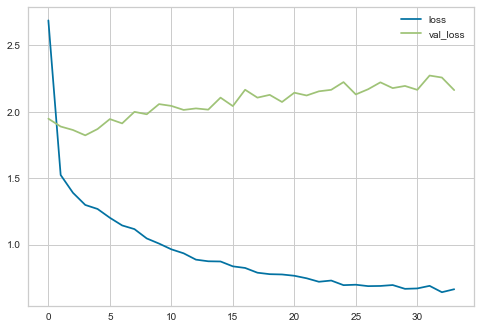

In [27]:
plt.plot(train_log.history["loss"], label="loss")
plt.plot(train_log.history["val_loss"], label="val_loss")
plt.legend()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Model test MSE : {mse}')
print(f'Model test MAE : {mae}')
print(f'Model test R2 : {r2}')

Model test MSE : 1.7343999517724953
Model test MAE : 1.097622357010698
Model test R2 : -2.36665469170379


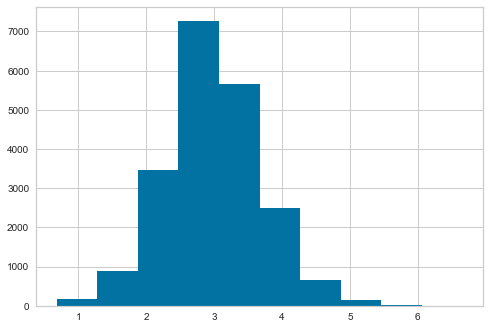

In [29]:
plt.hist(y_pred)
plt.hist(y_test, alpha=0.8)
plt.show()

### Grid Search Parameter

 57%|█████▋    | 4/7 [00:10<00:08,  2.74s/it]

KeyboardInterrupt: 

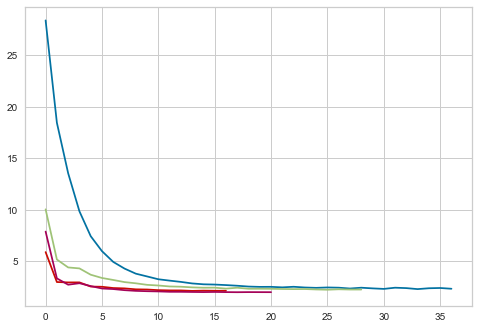

In [30]:
def grid_search(param, values, plot='loss'):
    scores = {param: ['Loss', 'MSE', 'MAE', 'R2']}
    
    if plot=='hist':
        plt.hist(y_test, label='True Vals')
    for value in tqdm(values):
        if param=='reg':
            model = neural_net(reg_val=value)
        elif param=='dropout':
            model = neural_net(drop=value)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        train_log = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])
        
        
        y_pred = model.predict(X_test)
        scores[value] = [train_log.history["val_loss"][-1], mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
        
        if plot=='loss':
            plt.plot(train_log.history["val_loss"], label=str(value))
        else:
            plt.hist(y_pred, alpha=0.5, label=str(value))
        
    plt.legend()
    plt.show()
    return scores

vals = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0]
# vals=[0.2,0.3,0.4,0.5,0.6,0.7]

scores = grid_search('reg', vals)
print(tabulate(scores, headers='keys', tablefmt='fancy_grid', numalign="right"))

In [ ]:
def show_pred_distribution(reg_val=l2_reg, drop=dropout_rate, loss=loss_fn, optim=optimizer):
    model = neural_net(reg_val=l2_reg, drop=dropout_rate, loss=loss_fn, optim=optimizer)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    train_log = model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=1, validation_split=0.2, callbacks=[early_stopping])
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Model test MSE : {mse}')
    print(f'Model test MAE : {mae}')
    print(f'Model test R2 : {r2}')
    
    plt.hist(y_pred)
    plt.hist(y_test, alpha=0.8)
    plt.show()
    
show_pred_distribution(reg_val=0.001)

### Latent Semantic Analysis

In [62]:
from sklearn.decomposition import TruncatedSVD

X = recipes.sort_index()
print(X.shape)

lsa = TruncatedSVD(250, algorithm = 'arpack')
lsa_out = lsa.fit_transform(X.T)
lsa_out_df = pd.DataFrame(lsa_out)

# print(lsa.explained_variance_ratio_.sum())
lsa_out_df.index = distance_matrix.index

(194717, 500)


ValueError: Length mismatch: Expected axis has 500 elements, new values have 490 elements

In [43]:
evr = []

lsa = TruncatedSVD(499, algorithm = 'arpack')
lsa_out = lsa.fit_transform(X.T)
lsa_out_df = pd.DataFrame(lsa_out)

for i in range(500):
    evr.append(lsa.explained_variance_ratio_[:i].sum())

<IPython.core.display.Javascript object>


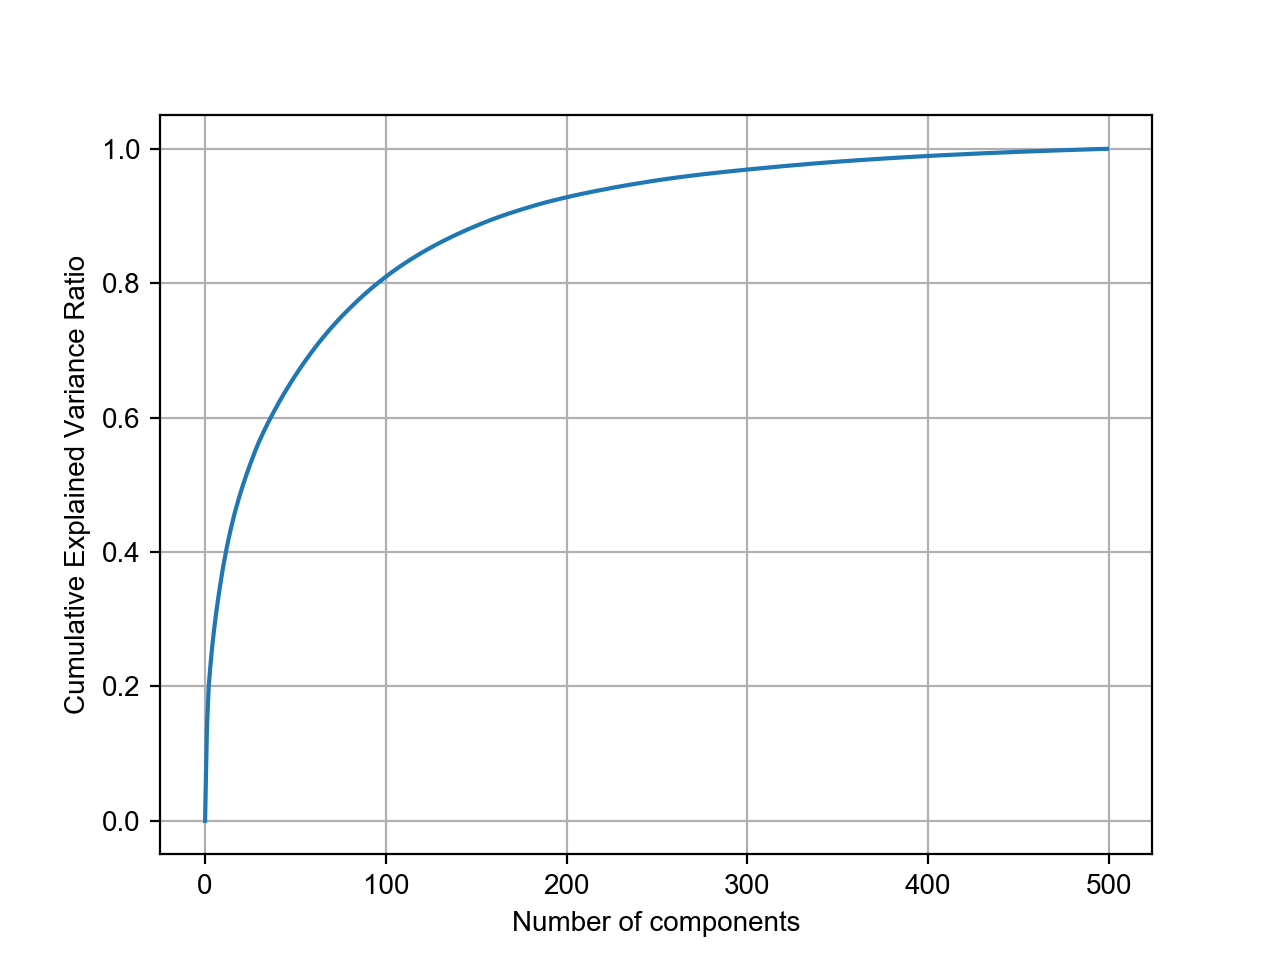

In [49]:
plt.figure()
plt.plot(evr)
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Number of Components vs Cumulative Explained Variance Ratio')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


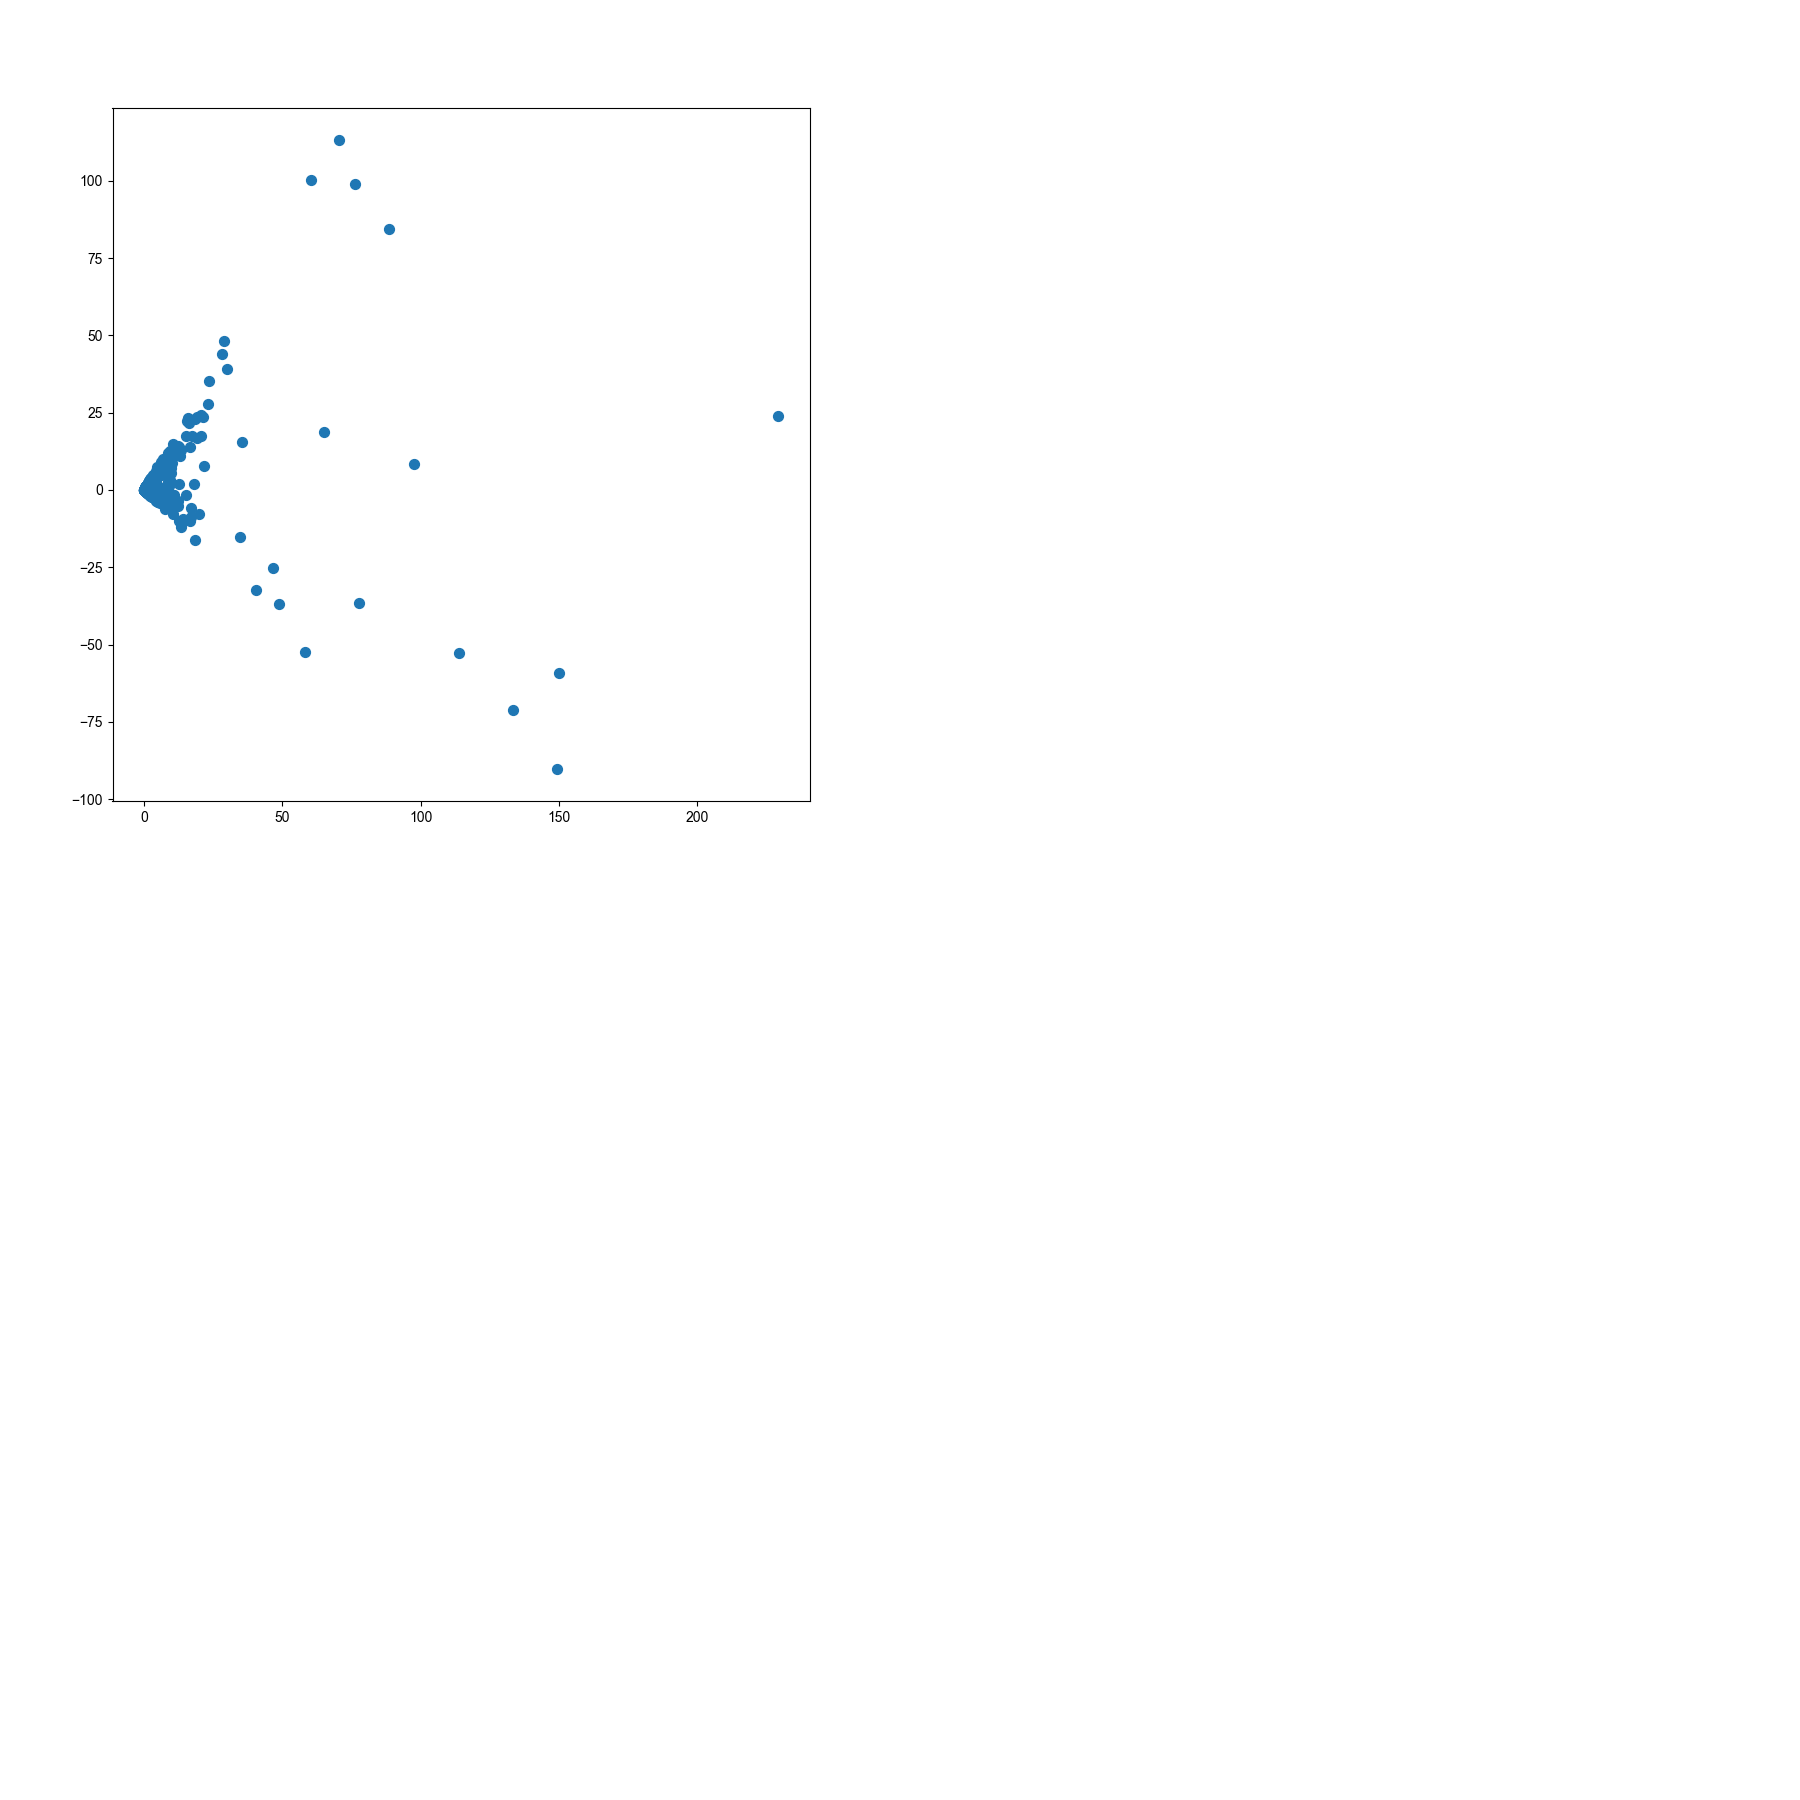

NameError: name 'distance_matrix' is not defined

In [28]:
# model = KMeans(3, random_state=RANDOM_SEED)
# clusters = model.fit_predict(X)

# plt.figure(figsize=(9,9))
# plt.scatter(lsa_out[:, 0], lsa_out[:, 1], s=50, cmap='viridis')

# for label in distance_matrix.index:
#     plt.annotate(label, (lsa_out_df.loc[label, 0], lsa_out_df.loc[label, 1]))
# plt.show()
# centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
# plt.show()

In [63]:
mds = MDS(n_components=2, 
           metric=True, 
           n_init=10, 
           max_iter=1000,
           random_state=RANDOM_SEED)

out = mds.fit_transform(lsa_out)


<IPython.core.display.Javascript object>


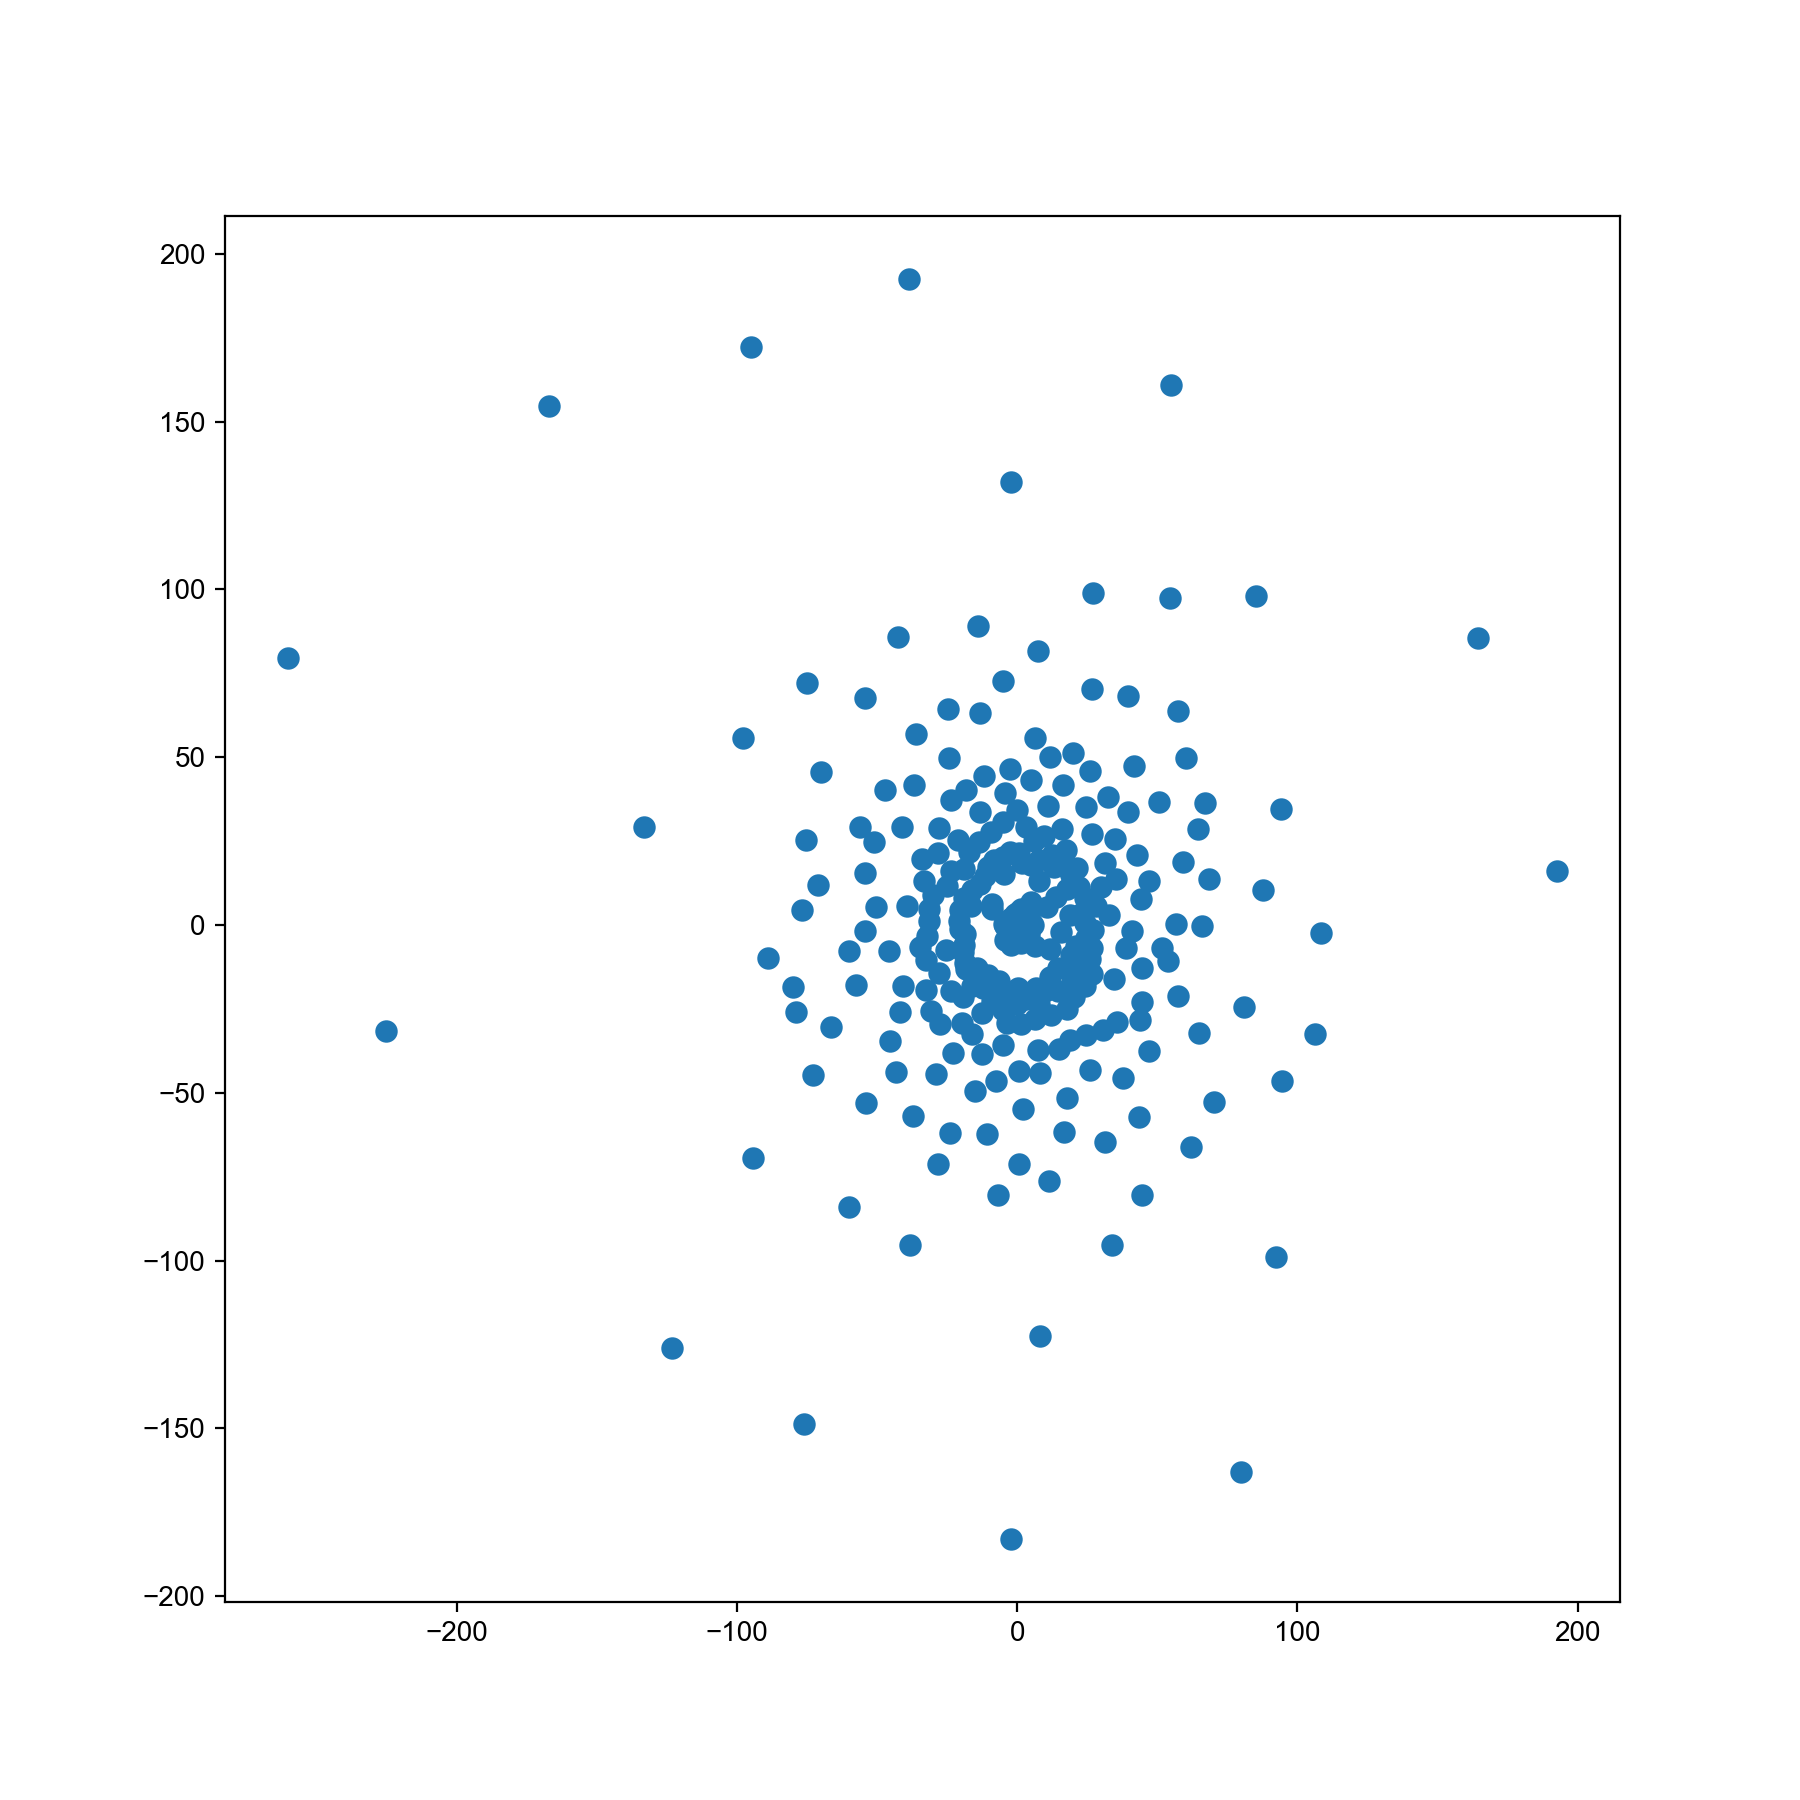

In [64]:
plt.figure(figsize=(9,9))
plt.scatter(out[:, 0], out[:, 1], s=50, cmap='viridis')
plt.show()

<IPython.core.display.Javascript object>


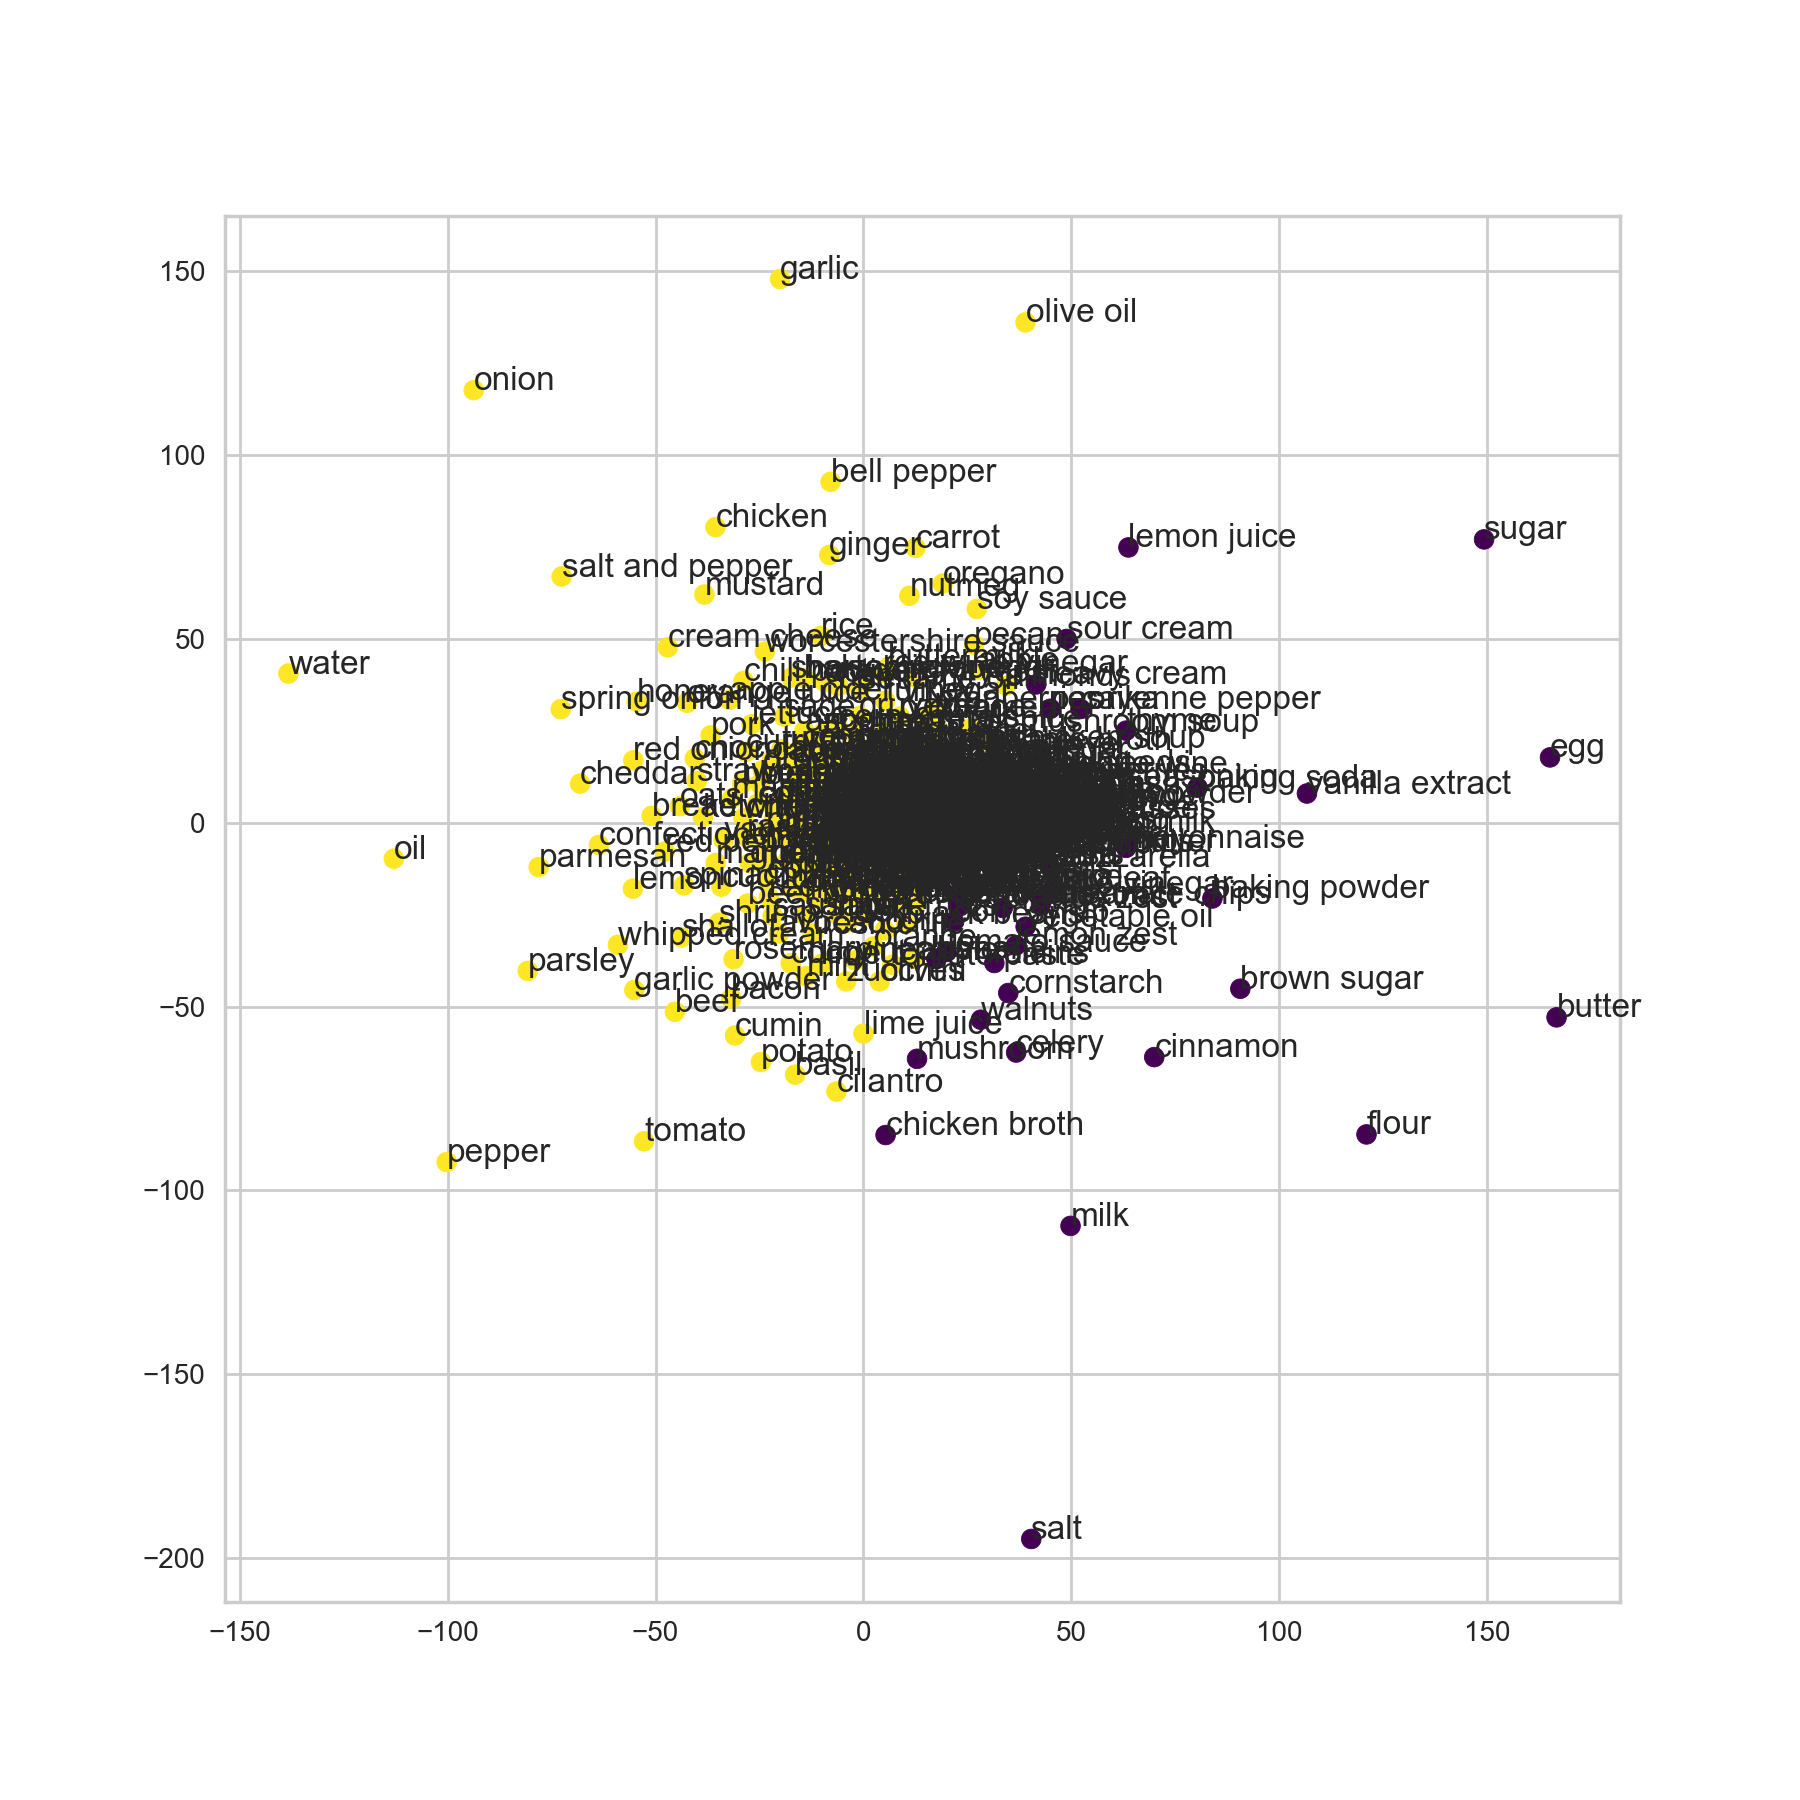

In [167]:
X = pd.DataFrame(out).replace([np.inf], np.nan)
X = X.replace(np.nan, X.max()*2 )
X = pd.DataFrame(out).replace([-np.inf], np.nan)
X = X.replace(np.nan, -X.max()*2 )

model = KMeans(2, random_state=RANDOM_SEED)
clusters = model.fit_predict(X)

plt.figure(figsize=(9,9))
plt.scatter(out[:, 0], out[:, 1], c=clusters, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

for idx, label in enumerate((mds_out['cluster']==1).index):
    plt.annotate(label, (out[idx, 0], out[idx, 1]))

plt.show()

In [166]:
mds_out = pd.DataFrame(out)
mds_out.index = pmi_matrix.index
mds_out.columns = 'X', 'Y'
mds_out['cluster'] = clusters
mds_out['cluster'].value_counts()

2    315
6     68
3     39
0     29
7     20
1     20
4      7
5      6
Name: cluster, dtype: int64

### Distances as Rating predictors  -- Mean MDS distance

In [40]:
ratings_sample = ratings['rating'].sample(frac=1, random_state=RANDOM_SEED)
recipes_sample = rated_recipes[rated_recipes.index.isin(ratings_sample.index)]
print(ratings_sample.shape)
print(recipes_sample.shape)

(102165,)
(71261, 250)


In [84]:
from sklearn.metrics.pairwise import euclidean_distances
from itertools import combinations
from statistics import mean, stdev, median


def calc_distance_row(recipe, ing_map, distance_fn):
    if recipe.sum() < 3:
        return pd.Series({'mean_dist':0, 
                      'stdev': 0, 
                      'median_dist': 0})
    ing_present = recipe[recipe == 1].index.tolist()
    pairs = combinations(ing_present, 2)
#     pairs = pd.DataFrame(np.transpose([np.tile(ing_present, len(ing_present)), np.repeat(ing_present, len(ing_present))]))
#     pairs.columns = 'ingredient_x', 'ingredient_y'
#     pairs = pairs[pairs['ingredient_x'] != pairs['ingredient_y']].reset_index()
    


    distances = []

    for idx, pair in enumerate(pairs):
        mds_ing_1 = ing_map.loc[pair[0]].values.reshape(1,-1)
        mds_ing_2 = ing_map.loc[pair[1]].values.reshape(1,-1)
        distances.append(distance_fn(mds_ing_1, mds_ing_2)[0][0])
        
    return pd.Series({'mean_dist':mean(distances), 
                      'stdev': stdev(distances), 
                      'median_dist': median(distances)})

def calc_distances(num_recipes, ing_map, distance_fn):
    X = pd.DataFrame()

    step = num_recipes // 20
    for i in tqdm(range(0, num_recipes, step)):
        tmp = recipes_sample.iloc[i : i+step]

        tmp2 = tmp.apply(calc_distance_row, ing_map=ing_map, distance_fn=distance_fn, axis=1)

        X = pd.concat([X, tmp2], sort=True)
    return X
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [87]:
y = ratings_sample.sort_index()

try:
    mds_map = mds_out_df.drop('cluster', axis=1)
except Exception as e :
    mds_map = mds_out_df

X_mds_euc = calc_distances(y.shape[0], mds_map, euclidean_distances)


100%|██████████| 21/21 [08:07<00:00, 23.23s/it]


In [57]:
# X.drop(0, inplace=True)
X_trunc = X_mds_euc[X_mds_euc['mean_dist']>0]
y_trunc = y[X_mds_euc['mean_dist']>0]
# distance_mds_ratings = pd.concat([X_trunc, y_trunc], axis=1)
# distance_mds_ratings.to_csv('dataset/distances/MDS.csv')

In [58]:
print(X_trunc['mean_dist'].corr(y_trunc['rating']))
print(X_trunc['stdev'].corr(y_trunc['rating']))
print(X_trunc['mean_dist'].corr(y_grouped['rating']))
print(X_trunc['stdev'].corr(y_grouped['rating']))

0.044012112545918136
0.03980416129911088


In [44]:
y_grouped = y_trunc.mask(y_trunc <= 3.6, 0)
y_grouped = y_grouped.mask(y_trunc > 3.6, 1)

In [31]:
print(rated_recipes[rated_recipes.index.isin(ratings_sample.index)])

ingredient                                          acorn squash  \
url                                                                
/recipes/food/views/-adult-pimiento-cheese-100852            0.0   
/recipes/food/views/-an-apple-a-day-51133430                 0.0   
/recipes/food/views/-bloody-mary-tomato-toast-w...           0.0   
/recipes/food/views/-candy-corn-pumpkin-blondie...           0.0   
/recipes/food/views/-chickpea-barley-and-feta-s...           0.0   
/recipes/food/views/-confetti-couscous-103396                0.0   
/recipes/food/views/-em-polow-em-persian-rice-w...           0.0   
/recipes/food/views/-em-polpette-em-torpedo-sha...           0.0   
/recipes/food/views/-em-yeabesha-gomen-em-colla...           0.0   
/recipes/food/views/-floating-islands-with-choc...           0.0   
/recipes/food/views/-fried-chicken-230295                    0.0   
/recipes/food/views/-hazelnut-butter-and-coffee...           0.0   
/recipes/food/views/-lentils-with-cucumbers-cha.

### Distances as rating predictors --- MDS cosine 10 components

In [506]:
from sklearn.metrics.pairwise import cosine_similarity

y = ratings_sample.sort_index()

try:
    mds_map = mds_out_df.drop('cluster', axis=1)
except Exception as e :
    mds_map = mds_out_df

X_mds_cos = calc_distances(y.shape[0], mds_map, cosine_similarity)





  0%|          | 0/21 [00:00<?, ?it/s]


  5%|▍         | 1/21 [00:31<10:35, 31.78s/it]


 10%|▉         | 2/21 [01:02<09:58, 31.51s/it]


 14%|█▍        | 3/21 [01:32<09:18, 31.01s/it]


 19%|█▉        | 4/21 [02:05<08:56, 31.57s/it]


 24%|██▍       | 5/21 [02:31<07:59, 29.98s/it]


 29%|██▊       | 6/21 [02:56<07:04, 28.29s/it]


 33%|███▎      | 7/21 [03:23<06:30, 27.92s/it]


 38%|███▊      | 8/21 [03:50<05:59, 27.66s/it]


 43%|████▎     | 9/21 [04:15<05:25, 27.12s/it]


 48%|████▊     | 10/21 [04:46<05:08, 28.06s/it]


 52%|█████▏    | 11/21 [05:21<05:02, 30.24s/it]


 57%|█████▋    | 12/21 [05:51<04:31, 30.15s/it]


 62%|██████▏   | 13/21 [06:21<04:01, 30.14s/it]


 67%|██████▋   | 14/21 [06:49<03:25, 29.40s/it]


 71%|███████▏  | 15/21 [07:18<02:55, 29.27s/it]


 76%|███████▌  | 16/21 [07:44<02:21, 28.25s/it]


 81%|████████  | 17/21 [08:10<01:50, 27.70s/it]


 86%|████████▌ | 18/21 [08:42<01:26, 28.95s/it]


 90%|█████████ | 19/21 [09:12<00:58, 29.37s/it]


 95%|█████████▌

In [64]:
X_trunc = X_mds_cos[X_mds_cos['mean_dist']>0]
y_trunc = y[X_mds_cos['mean_dist']>0]
print(X_trunc['mean_dist'].corr(y_trunc['rating']))
print(X_trunc['stdev'].corr(y_trunc['rating']))
print(X_trunc['mean_dist'].corr(y_grouped['rating']))
print(X_trunc['stdev'].corr(y_grouped['rating']))

0.04899832495217983
-0.04520769575673508
0.034833278672380265
-0.03673327910324883


### Distances as rating predictors --- LSA cosine 2 components

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

y = ratings_sample.sort_index()

try:
    lsa_map = lsa_out_df.drop('cluster', axis=1)
except Exception as e :
    lsa_map = lsa_out_df

X_lsa_cos = calc_distances(y.shape[0], lsa_map, cosine_similarity)


### Distances as rating predictors --- PMI cosine 10 components

In [507]:
from sklearn.metrics.pairwise import cosine_similarity

y = ratings_sample.sort_index()

try:
    pmi_map = pmi_out.drop('cluster', axis=1)
except Exception as e :
    pmi_map = pmi_out

X_pmi_cos = calc_distances(y.shape[0], pmi_map, cosine_similarity)





  0%|          | 0/21 [00:00<?, ?it/s]


AttributeError: ("'numpy.ndarray' object has no attribute 'loc'", 'occurred at index http://allrecipes.com/Recipe/10000/')

In [66]:
X_trunc = X_pmi_cos[X_pmi_cos['mean_dist']>0]
y_trunc = y[X_pmi_cos['mean_dist']>0]
print(X_trunc['mean_dist'].corr(y_trunc['rating']))
print(X_trunc['stdev'].corr(y_trunc['rating']))
print(X_trunc['mean_dist'].corr(y_grouped['rating']))
print(X_trunc['stdev'].corr(y_grouped['rating']))

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

### Distances as rating predictors --- PMI euclidean 10 components

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

y = ratings_sample.sort_index()

try:
    pmi_map = pmi_out.drop('cluster', axis=1)
except Exception as e :
    pmi_map = pmi_out

X_pmi_euc = calc_distances(y.shape[0], pmi_map, euclidean_distances)



In [ ]:
X_trunc = X_pmi_euc[X_pmi_euc['mean_dist']>0]
y_trunc = y[X_pmi_euc['mean_dist']>0]
print(X_trunc['mean_dist'].corr(y_trunc['rating']))
print(X_trunc['stdev'].corr(y_trunc['rating']))
print(X_trunc['mean_dist'].corr(y_grouped['rating']))
print(X_trunc['stdev'].corr(y_grouped['rating']))

### Mini Classification test

In [121]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


#### Set input

In [122]:
rated_recipes_count = rated_recipes.sum(axis=1)

X = X_mds_euc
X = X[X['mean_dist']>0]
X['count'] = rated_recipes_count[rated_recipes_count.index.isin(X.index)]
X.sort_index()

NameError: name 'X_mds_euc' is not defined

In [92]:
from keras.utils import to_categorical

ratings['class'] = ratings['rating'].mask(ratings['rating'] > 0, 2)   # rating > 4.4
ratings['class'] = ratings['class'].mask(ratings['rating'] <= 4.4, 1)    # 3.7 < rating <= 4.4
ratings['class'] = ratings['class'].mask(ratings['rating'] <= 3.7, 0)    # rating <= 3.7

tmp = ratings['class'][ratings['class'].index.isin(X.index)]
tmp.sort_index()

y = to_categorical(tmp)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


<IPython.core.display.Javascript object>


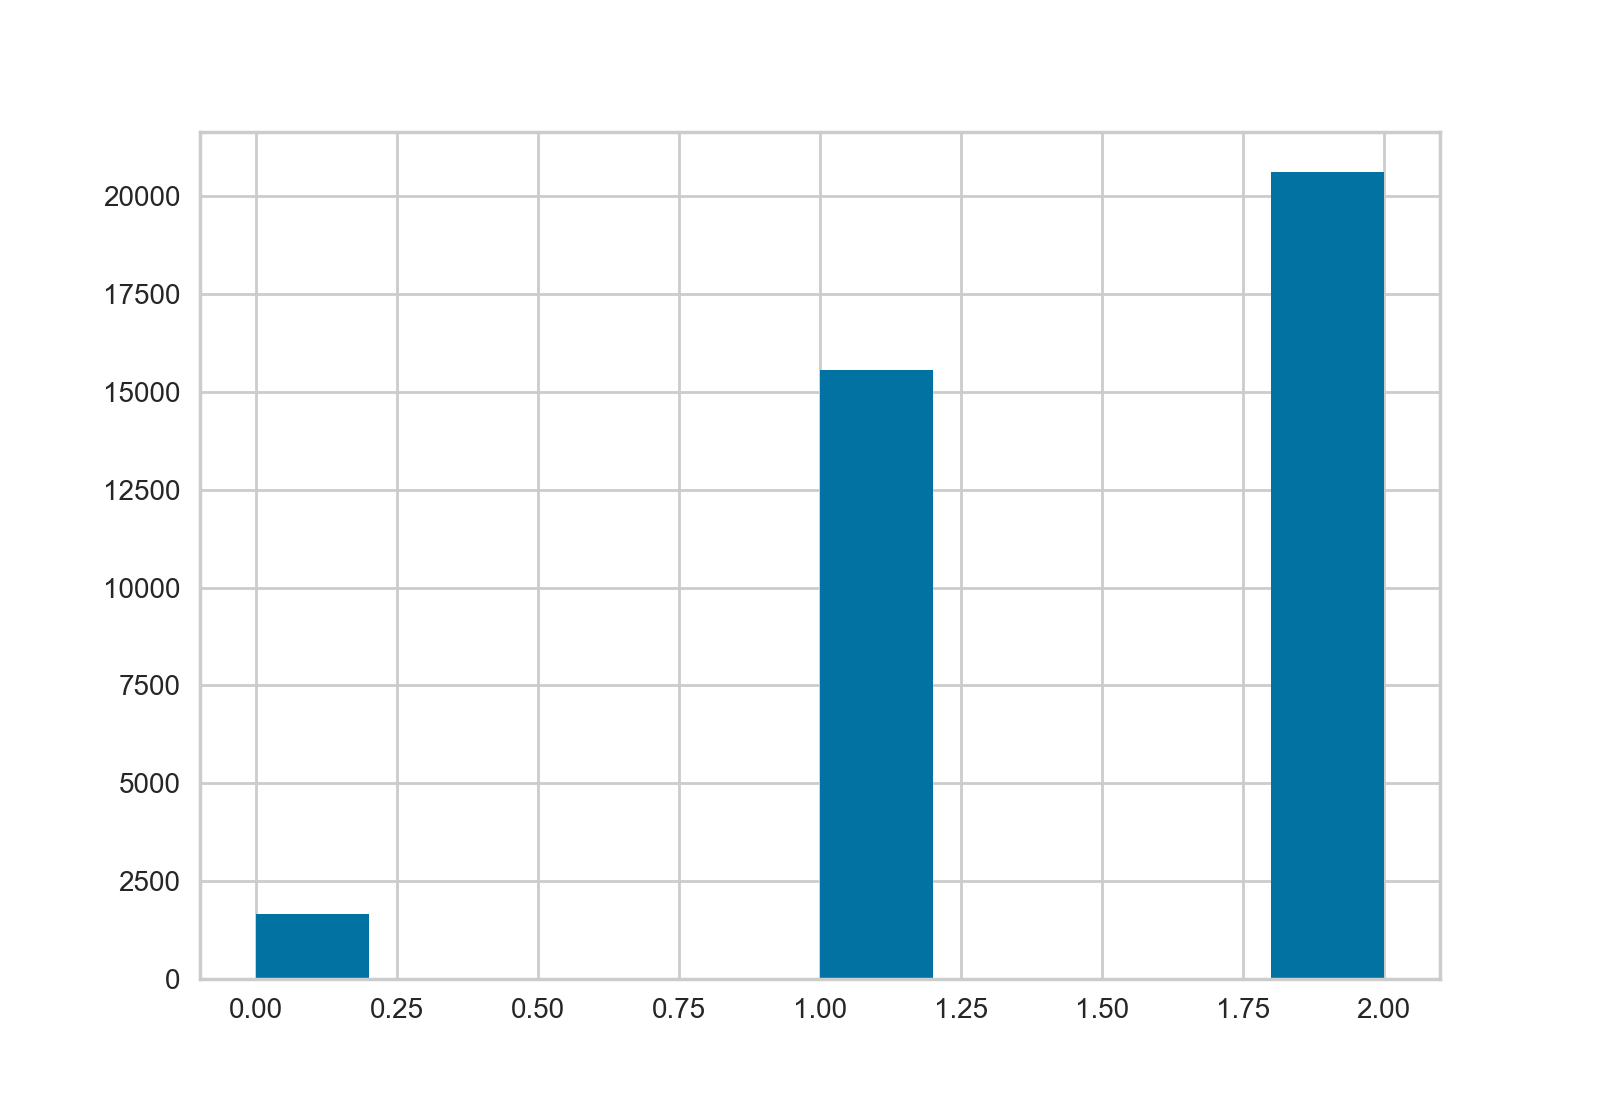

In [93]:
plt.figure()
plt.hist(ratings['class'])
plt.show()

In [98]:
activ_fn = 'relu'
kernel_init = 'glorot_uniform'

loss_fn = 'categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(
                                    learning_rate=0.0001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    amsgrad=False
                                )
dropout_rate = 0.5
l2_reg = 0.001

def neural_net(reg_val=l2_reg, drop=dropout_rate, loss=loss_fn, optim=optimizer):
    model = Sequential()
#     model.add( Dense(30, input_dim=(3), activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
#     model.add( Dense(500, activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
#     model.add( Dense(200, activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
    model.add( Dense(60, input_dim=(4), activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    model.add( Dense(20, activation=activ_fn, kernel_initializer=kernel_init) )
    model.add( Dense(3, activation='softmax', kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    
    model.compile(loss=loss_fn, optimizer=optim)
    return model

model = neural_net()

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
train_log = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Train on 22953 samples, validate on 5739 samples
Epoch 1/200
22953/22953 [==============================] - 2s 68us/sample - loss: 0.8895 - val_loss: 0.8550
Epoch 2/200
22953/22953 [==============================] - 1s 47us/sample - loss: 0.8587 - val_loss: 0.8530
Epoch 3/200
22953/22953 [==============================] - 1s 44us/sample - loss: 0.8566 - val_loss: 0.8512
Epoch 4/200
22953/22953 [==============================] - 1s 46us/sample - loss: 0.8552 - val_loss: 0.8502
Epoch 5/200
22953/22953 [==============================] - 1s 48us/sample - loss: 0.8538 - val_loss: 0.8490
Epoch 6/200
22953/22953 [==============================] - 1s 47us/sample - loss: 0.8534 - val_loss: 0.8484
Epoch 7/200
22953/22953 [==============================] - 1s 46us/sample - loss: 0.8527 - val_loss: 0.8490
Epoch 8/200
22953/22953 [==============================] - 1s 46us/sample - loss: 0.8515 - val_loss: 0.8479
Epoch 9/200
22953/22953 [==============================] - 1s 52us/sample - loss: 0.851

In [100]:
plt.figure()
plt.plot(train_log.history["loss"], label="loss")
plt.plot(train_log.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [101]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# y_pred = pd.Series(y_pred).argmax()
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Model test MSE : {mse}')
# print(f'Model test MAE : {mae}')
# print(f'Model test R2 : {r2}')
print(classification_report(y_test.argmax(axis=-1), y_pred.argmax(axis=-1)))
# print(y_test.argmax(axis=-1))
# print(y_pred.argmax(axis=-1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.50      0.00      0.00      2961
           2       0.55      1.00      0.71      3910

    accuracy                           0.55      7173
   macro avg       0.35      0.33      0.24      7173
weighted avg       0.50      0.55      0.39      7173



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Merge Features




Might crash here due to dataframes eminating from distance code yielding 4 columns instead of 3 ---> indeces might be being used assigned to column rather than index

In [102]:
X_mds_euc.head()

mean_dist  median_dist     stdev
url                                                                   
http://allrecipes.com/Recipe/10000/    5.898844     7.780072  4.573416
http://allrecipes.com/Recipe/100008/   5.658954     5.549126  5.295981
http://allrecipes.com/Recipe/10001/    5.050762     2.148859  4.717122
http://allrecipes.com/Recipe/100011/   4.178941     2.332929  4.265447
http://allrecipes.com/Recipe/10003/    6.581954     9.852996  4.542252

In [106]:
from sklearn import preprocessing

rated_recipes_count = rated_recipes.sum(axis=1)

X = X_mds_euc
X = X[X['mean_dist']>0]
X['count'] = rated_recipes_count[rated_recipes_count.index.isin(X.index)]
X.sort_index()

# X = pd.concat([X_mds_cos[X_mds_cos['mean_dist']>0], X_pmi_cos[X_mds_cos['mean_dist']>0]], axis=1).sort_index()

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_tmp = pd.DataFrame(x_scaled)
X_tmp.index = X[X['mean_dist']>0].index

X = X_tmp

X['count'] = rated_recipes_count[rated_recipes_count.index.isin(X.index)]
print(X.shape)

(35865, 5)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [113]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rated_recipes_count = rated_recipes.sum(axis=1)

y = ratings_sample[ratings_sample.index.isin(X.index)]
# y = y[X[0]>0].sort_index()


# source = 'allrecipes'
# source = 'cookstr'
# source = 'recipes/food'

# print(X.shape)
# print(y.shape)
# print()
# X_onesource = X[X.index.str.contains(source)]
# y_onesource = y[y.index.str.contains(source)]
# print(X_onesource.shape)
# print(X_onesource.shape)
# print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# X_train, y_train = uniform_sampling(X_train, y_train)


regr_stats = {
    'Model' : ['MSE', 'MAE', 'R2']
}

models = [SVR, LinearRegression, Ridge, Lasso, BayesianRidge, HuberRegressor, RandomForestRegressor]

fn_to_name = {
    SVR : 'SVR',
    LinearRegression: 'L-Regression', 
    Ridge : 'Ridge',
    BayesianRidge: 'B-Ridge',
    Lasso : 'Lasso',
    HuberRegressor : 'H-Regressor',
    RandomForestRegressor : 'RandomForest'
}

for model in tqdm(models):

    reg = model()

    reg = reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mse = round(mean_squared_error(y_test, y_pred),2)
    mae = round(mean_absolute_error(y_test, y_pred),2)
    r2 = round(r2_score(y_test, y_pred),2)

    regr_stats[fn_to_name[model]] = [mse, mae, r2]
    

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [114]:
print(tabulate(regr_stats, headers='keys', tablefmt='fancy_grid', numalign="right"))

╒═════════╤═══════╤════════════════╤═════════╤═════════╤═══════════╤═══════════════╤════════════════╕
│ Model   │   SVR │   L-Regression │   Ridge │   Lasso │   B-Ridge │   H-Regressor │   RandomForest │
╞═════════╪═══════╪════════════════╪═════════╪═════════╪═══════════╪═══════════════╪════════════════╡
│ MSE     │  0.11 │           0.11 │    0.11 │    0.11 │      0.11 │          0.11 │           0.13 │
├─────────┼───────┼────────────────┼─────────┼─────────┼───────────┼───────────────┼────────────────┤
│ MAE     │  0.25 │           0.25 │    0.25 │    0.25 │      0.25 │          0.25 │           0.28 │
├─────────┼───────┼────────────────┼─────────┼─────────┼───────────┼───────────────┼────────────────┤
│ R2      │ -0.03 │             -0 │      -0 │      -0 │        -0 │         -0.02 │          -0.21 │
╘═════════╧═══════╧════════════════╧═════════╧═════════╧═══════════╧═══════════════╧════════════════╛
